<a href="https://colab.research.google.com/github/superbb/kaggle-fun/blob/colab/Feature_Engineering_for_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering for House Prices Competition

This notebook focuses on data exploration, preprocessing, and feature engineering for the [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) Kaggle competition. It was built in Colab to take advantage of its display and navigation features, but should work across platforms.

[TODO: Add github link]

# Step 1 - Preliminaries

This section sets up the analysis for the House Prices competition, following the [original lab](https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices) structure. It is divided into subsections for clarity:

- **Step 1A: Kaggle Connection** - Configures access to Kaggle data (for Colab).
- **Step 1B: Imports and Configurations** - Imports data and Python libraries for analysis.
- **Step 1C: Data Exploration** - Examines the dataset for missing values, creates groupings to analyze trends, and plans imputation strategies.
- **Step 1D: Preprocessing** - Builds a pipeline to load, clean, encode, impute, and verify data transformations.
- **Step 1E: Baseline** - Establishes a baseline score to evaluate feature engineering improvements.

##  1A: Google Colab - Kaggle API Connection



In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.

import kagglehub
import os

# Get Kaggle credentials from Colab Secrets
try:
  from google.colab import userdata
  kaggle_username = userdata.get('KAGGLE_USERNAME')
  kaggle_token = userdata.get('KAGGLE_TOKEN')
except ImportError:
  kaggle_username = os.getenv('KAGGLE_USERNAME')
  kaggle_key = os.getenv('KAGGLE_KEY')

# Verify credentials and login
if not kaggle_username or not kaggle_token:
  raise ValueError("Kaggle credentials not found in Colab Secrets."
        "Set 'KAGGLE_USERNAME' and 'KAGGLE_TOKEN' in Secrets or equivalent.")

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_token

try:
  kagglehub.login()
  print("KaggleHub login successful!")
except Exception as e:
  print(f"Error during KaggleHub login: {e}")

KaggleHub login successful!


## 1B: Imports and Configuration ##

Imports libraries and configures settings for data analysis, including interactive table display for Colab.

In [ ]:
try:
  kaggle_path = "../input/house-prices-advanced-regression-techniques/"
  if os.path.exists(kaggle_path):
    data_path = kaggle_path
  else:
    data_path = kagglehub.competition_download('house-prices-advanced-regression-techniques')
  print('Data source import complete.')
except Exception as e:
  print(f"Failed to set dataset path: {e}")

100%|██████████| 199k/199k [00:00<00:00, 835kB/s]

Extracting files...
Data source import complete.


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

# Set Matplotlib visualization defaults
plt.style.use("ggplot")  # Standard, non-deprecated style
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Enable Colab's interactive table formatter for enhanced DataFrame display
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
except ImportError:
    pass  # Skip in non-Colab environments (e.g., Kaggle, Jupyter)

## 1C: Data Exploration

Examines the House Prices dataset for missing values, creates groupings to analyze trends, and plans imputation strategies for feature engineering.

### Load Data and Create Feature Groupings for Exploration

In [ ]:
data_dir = Path(data_path)
df_train_explore = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test_explore = pd.read_csv(data_dir / "test.csv", index_col="Id")
df_both_explore = pd.concat([df_train_explore, df_test_explore])

Groups features like YearBuilt and LotArea to simplify trend analysis.

In [5]:
def new_df_cols(field_new, field_original, function):
    # Apply function to create new column across DataFrames
    for df in [df_train_explore, df_test_explore, df_both_explore]:
        df[field_new] = df[field_original].apply(function)

def round_to_10(x): return int(round(x // 10) * 10)
def round_to_25(x): return int(round(x // 25) * 25)
def round_to_50(x): return int(round(x // 50) * 50)

def scale_10_to_3(old_value):
    # Convert 10-point to 3-point scale
    if pd.isna(old_value):
        return np.nan
    return int(round(((old_value - 1) * 2 / 9) + 1))

def create_bins(df, field_original, field_new, label_list):
    # Generate quantile-based bins for numeric column
    df[field_new] = pd.qcut(df[field_original], q=len(label_list), labels=label_list)

def combine_cols(df, col1, col2, new_col=None):
    # Merge two columns into one with string concat
    if new_col is None:
        new_col = f"{col1}_{col2}"
    df[new_col] = df[col1].astype(str) + '_' + df[col2].astype(str)

# Create feature groupings
new_df_cols('YearBuilt10', 'YearBuilt', round_to_10)
new_df_cols('YearRemodAdd10', 'YearRemodAdd', round_to_10)
new_df_cols('YearBuilt25', 'YearBuilt', round_to_25)
new_df_cols('YearRemodAdd25', 'YearRemodAdd', round_to_25)
new_df_cols('YearBuilt50', 'YearBuilt', round_to_50)
new_df_cols('YearRemodAdd50', 'YearRemodAdd', round_to_50)
new_df_cols('OverallQual3', 'OverallQual', scale_10_to_3)
new_df_cols('OverallCond3', 'OverallCond', scale_10_to_3)

three_bins = ['Small', 'Medium', 'Large']
four_bins = ['Small', 'Medium', 'Large', 'XLarge']
five_bins = ['VerySmall', 'Small', 'Medium', 'Large', 'XLarge']

for df in [df_train_explore, df_test_explore, df_both_explore]:
    combine_cols(df, 'YearBuilt10', 'YearRemodAdd10', 'YearBuiltRemod10')
    combine_cols(df, 'YearBuilt10', 'YearRemodAdd25', 'YearBuilt10Remod25')
    combine_cols(df, 'YearBuilt25', 'YearRemodAdd25', 'YearBuiltRemod25')
    combine_cols(df, 'YearBuilt50', 'YearRemodAdd50', 'YearBuiltRemod50')
    combine_cols(df, 'OverallQual3', 'OverallCond3', 'OverallQualCond3')
    combine_cols(df, 'Exterior1st', 'Exterior2nd', 'Exteriors')
    create_bins(df, 'LotArea', 'LotAreaBins3', three_bins)
    create_bins(df, 'LotArea', 'LotAreaBins4', four_bins)
    create_bins(df, 'LotArea', 'LotAreaBins5', five_bins)

Validate feature groupings.

In [9]:
# Check summaries for a few features
cols = ['YearBuiltRemod25', 'YearBuilt10Remod25', 'OverallQualCond3']
print(df_both_explore[cols].describe())

print('\n YearBuiltRemod Breakdown (Top 5)')
print(pd.DataFrame([df_both_explore['YearBuiltRemod25'].value_counts().head(5).to_dict()]))

print('\n YearBuilt10Remod25 Breakdown (Top 5)')
print(pd.DataFrame([df_both_explore['YearBuilt10Remod25'].value_counts().head(5).to_dict()]))

print('\n OverallQualCond Breakdown (Top 10)')
print(pd.DataFrame([df_both_explore['OverallQualCond3'].value_counts().head(10).to_dict()]))

# Check LotArea bin distributions
cols = ['LotAreaBins5', 'LotArea']
print("\nLotArea bin distribution:")
print(df_both_explore.groupby('LotAreaBins5', observed=False)['LotArea'].describe().astype(int))

       YearBuiltRemod25 YearBuilt10Remod25 OverallQualCond3
count              2919               2919             2919
unique               16                 37                9
top           2000_2000          2000_2000              2_2
freq                783                780             2168

 YearBuiltRemod Breakdown (Top 5)
   2000_2000  1950_1950  1975_1975  1925_1950  1900_1950
0        783        646        583        211        153

 YearBuilt10Remod25 Breakdown (Top 5)
   2000_2000  1990_1975  1960_1950  1950_1950  1970_1975
0        780        297        273        239        190

 OverallQualCond Breakdown (Top 10)
    2_2  3_2  2_3  2_1  1_2  1_1  3_3  1_3  3_1
0  2168  464  169   45   35   20   14    2    2

LotArea bin distribution:
              count   mean    std    min    25%    50%    75%     max
LotAreaBins5                                                         
VerySmall       584   4619   1685   1300   3182   4921   6120    7007
Small           585   7908  

### Explore Categorical Values

Analyzes categorical features for gaps, distributions, and validation

#### Summarize Data Gaps ####

I check both the train and test set for gaps. There are actually more in the test set than the train set.

##### Functions #####


Outline all possible values. Based on the data definitions.

In [ ]:
possible_values = {
    'Alley': ['Grvl', 'Pave', 'NA'],
    'BldgType': ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI'],
    'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
    'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'CentralAir': ['N', 'Y'],
    'Condition1': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'Condition2': ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn', 'PosN', 'PosA', 'RRNe', 'RRAe'],
    'Electrical': ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Exterior1st': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'Exterior2nd': ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],
    'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone', 'Wood'],
    'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
    'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
    'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'GarageType': ['2Types', 'Attchd', 'Basment', 'BuiltIn', 'CarPort', 'Detchd', 'NA'],
    'Heating': ['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall'],
    'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'HouseStyle': ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl'],
    'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'LandContour': ['Lvl', 'Bnk', 'HLS', 'Low'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'LotConfig': ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3'],
    'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
    'MasVnrType': ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone'],
    'MiscFeature': ['Elev', 'Gar2', 'Othr', 'Shed', 'TenC', 'NA'],
    'MSSubClass': [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    'MSZoning': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM'],
    'Neighborhood': ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker'],
    'OverallCond': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    'OverallQual': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    'PavedDrive': ['Y', 'P', 'N'],
    'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
    'RoofMatl': ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl'],
    'RoofStyle': ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'],
    'SaleCondition': ['Normal', 'Abnorml', 'AdjLand', 'Alloca', 'Family', 'Partial'],
    'SaleType': ['WD', 'CWD', 'VWD', 'New', 'COD', 'Con', 'ConLw', 'ConLI', 'ConLD', 'Oth'],
    'Street': ['Grvl', 'Pave'],
    'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']}

Helper Functions

In [ ]:
def review_cat_values(df, pv, treat_na_as_nan=False, show_all_values=True):
    """
    Review df values vs permitted values (pv) and highlight errors

    Args:
        df (pd.DataFrame): The DataFrame to check.
        pv (dict): Dict of column name : list of allowed values for that column.
        treat_na_as_nan (bool): If True, treat 'NA' and NaN as equivalent.
        show_all_values (bool): Include all values in pv--with 0s if needed.

    Returns:
         dict: A dictionary column name to tuples (value, count, is_invalid)
    """
    values = {}
    for col in df.columns:
        if col in pv:
            valid_set = set(pv[col])  # Convert list to set
            # Get all unique values and their counts
            counts = df[col].value_counts(dropna=False)
            distribution = []
            # Handle non-NaN and NaN values
            seen_values = set(counts.index)
            for val in counts.index:
                is_invalid = pd.isna(val) or val not in valid_set
                # When treat_na_as_nan=True, treat 'NA' and NaN as equivalent
                if treat_na_as_nan:
                    if val == 'NA' or pd.isna(val):
                        is_invalid = 'NA' not in valid_set
                distribution.append((val, counts[val], is_invalid))

            # Add possible values with 0 counts if requested
            if show_all_values:
                for val in pv[col]:
                    if val not in seen_values and not pd.isna(val):  # Skip NaN as it's already handled
                        is_invalid = val not in valid_set  # Should be False since val is in pv[col]
                        distribution.append((val, 0, is_invalid))

            # Store possible values and distribution
            values[col] = distribution
    return values

def print_review_cat_values(values, skip_valid_columns=True):
    """Print distribution and out of scope values in a table-like format.

    Args:
        values: Dictionary from review_values.
        skip_valid_columns: If True, skip columns with no out-of-scope values.
    """
    for col, info in values.items():
        # Prepare distribution, optionally skipping NaN
        dist = [(v, c, is_invalid) for v, c, is_invalid in info]
        # Prepare out-of-scope values, optionally skipping NaN
        out_of_scope = [(v, c) for v, c, is_invalid in dist if is_invalid]
        # Skip column if no out-of-scope values and skip_valid_columns is True
        if skip_valid_columns and not out_of_scope:
            continue

        # Prepare strings
        dist_str = ', '.join(
            f"**{v} ({c})**" if is_invalid else f"{v} ({c})"
            for v, c, is_invalid in dist
        ) or "None"
        oos_str = ', '.join(
            f"{v} ({c})"
            for v, c in out_of_scope
        ) or "None"

        print(f"{col}: {oos_str} \n  Distribution: {dist_str}")

In [ ]:
def explore_feature_counts(dfs: List[pd.DataFrame],
                           df_names: List[str],
                           target_col: str,
                           filters: Dict[str, Union[str, int, List, Tuple]],
                           print_title: bool = True) -> pd.DataFrame:
    """
    Generate a table of counts for a target column based on specified filters across multiple DataFrames.
    If no filters are provided, computes global tallies for the target column.

    Parameters:
    - dfs: List of pandas DataFrames to analyze
    - df_names: List of names for the DataFrames (used as column headers)
    - target_col: The column to explore (e.g., 'MSZoning')
    - filters: Dictionary of column-value pairs for exact matches (e.g., {'BldgType': '1Fam'}).
               Values can be a single value (str/int) or a list/tuple of values (e.g., {'Neighborhood': ['Nevil', 'Mitchel']})
               for matching any of the specified values.
               If empty, computes global counts.
    - print_title: If True, prints a title summarizing the target column and filter values

    Returns:
    - A DataFrame with target column values, counts for each DataFrame, and a total count, sorted by total in descending order
    """
    if len(dfs) != len(df_names):
        raise ValueError("Number of DataFrames must match number of DataFrame names")

    # Helper function to format filter for title
    def format_filter(col: str, filt: Union[str, int, List, Tuple]) -> str:
        if isinstance(filt, (list, tuple)):
            return f"{col} = {' or '.join(str(v) for v in filt)}"
        return f"{col} = {filt}"

    # Print title if requested
    if print_title:
        if filters:
            filter_strings = [format_filter(col, val) for col, val in filters.items()]
            filter_values = ', '.join(filter_strings)
            print(f"\nSummary for {target_col} for {filter_values}:")
        else:
            print(f"\nSummary for {target_col} (Global):")

    # Initialize a dictionary to store value counts for each DataFrame
    counts_dict = {}

    # Process each DataFrame
    for df, df_name in zip(dfs, df_names):
        # Apply filters if provided; otherwise, use the full DataFrame
        filtered_df = df.copy()
        if filters:
            for col, val in filters.items():
                if isinstance(val, (list, tuple)):
                    filtered_df = filtered_df[filtered_df[col].isin(val)]
                else:
                    filtered_df = filtered_df[filtered_df[col] == val]

        # Get value counts for the target column
        counts = filtered_df[target_col].value_counts().to_frame(name=df_name)
        counts_dict[df_name] = counts

    # Combine all counts into a single DataFrame
    result = pd.concat(counts_dict.values(), axis=1, sort=True)

    # Fill NaN with 0 (for values not present in some DataFrames)
    result = result.fillna(0).astype(int)

    # Calculate total counts
    result['Total'] = result.sum(axis=1)

    # Sort by total in descending order
    result = result.sort_values('Total', ascending=False)

    # Reset index to make target_col a column
    result = result.reset_index().rename(columns={'index': target_col})

    return result

##### Summary #####

In [ ]:
train_explore = review_cat_values(df_train_explore, possible_values, treat_na_as_nan=True)
print("=== Train ===")
print_review_cat_values(train_explore)

test_explore = review_cat_values(df_test_explore, possible_values, treat_na_as_nan=True)
print("\n=== Test ===")
print_review_cat_values(test_explore)

=== Train ===
MSZoning: C (all) (10) 
  Distribution: RL (1151), RM (218), FV (65), RH (16), **C (all) (10)**, A (0), C (0), I (0), RP (0)
Neighborhood: NAmes (225) 
  Distribution: **NAmes (225)**, CollgCr (150), OldTown (113), Edwards (100), Somerst (86), Gilbert (79), NridgHt (77), Sawyer (74), NWAmes (73), SawyerW (59), BrkSide (58), Crawfor (51), Mitchel (49), NoRidge (41), Timber (38), IDOTRR (37), ClearCr (28), SWISU (25), StoneBr (25), Blmngtn (17), MeadowV (17), BrDale (16), Veenker (11), NPkVill (9), Blueste (2), Names (0)
BldgType: Duplex (52), Twnhs (43), 2fmCon (31) 
  Distribution: 1Fam (1220), TwnhsE (114), **Duplex (52)**, **Twnhs (43)**, **2fmCon (31)**, 2FmCon (0), Duplx (0), TwnhsI (0)
Exterior2nd: CmentBd (60), Wd Shng (38), Brk Cmn (7) 
  Distribution: VinylSd (504), MetalSd (214), HdBoard (207), Wd Sdng (197), Plywood (142), **CmentBd (60)**, **Wd Shng (38)**, Stucco (26), BrkFace (25), AsbShng (20), ImStucc (10), **Brk Cmn (7)**, Stone (5), AsphShn (3), Other (1)

Now that we see where we have gaps, let's explore feature by feature.

#### MSZoning ####

In [ ]:
cols = ['MSZoning', 'Neighborhood', 'BldgType', 'LotConfig', 'HouseStyle', 'LotShape']
mask = df_both_explore['MSZoning'].isna()
df_both_explore.loc[mask, cols]

,MSZoning,Neighborhood,BldgType,LotConfig,HouseStyle,LotShape
Id,,,,,,
1916,NaN,IDOTRR,1Fam,Inside,1Story,Reg
2217,NaN,IDOTRR,1Fam,Inside,1Story,Reg
2251,NaN,IDOTRR,1Fam,Inside,2.5Unf,IR1
2905,NaN,Mitchel,1Fam,Inside,1Story,Reg


Drilling into breakdowns within the features.

In [ ]:
# Counts of MSZoning globally
dfs = [df_train_explore, df_test_explore]
df_names = ['Train', 'Test']
target_col = 'MSZoning'
filters = {}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'Neighborhood': 'IDOTRR',
    'HouseStyle': '1Story',
    'LotShape': 'Reg'}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters.update({'HouseStyle': '2.5Unf', 'LotShape': 'IR1'})
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'Neighborhood': 'Mitchel',
    'HouseStyle': '1Story',
    'LotShape': 'Reg'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'HouseStyle': '1Story',
    'LotShape': 'Reg'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'HouseStyle': '1Story',
    'Neighborhood': 'IDOTRR'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'HouseStyle': '2.5Unf',
    'Neighborhood': 'IDOTRR'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'HouseStyle': '1Story',
    'Neighborhood': 'Mitchel'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'Neighborhood': 'IDOTRR'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'LotConfig': 'Inside',
    'Neighborhood': 'Mitchel'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))


Summary for MSZoning (Global):
  MSZoning  Train  Test  Total
0       RL   1151  1114   2265
1       RM    218   242    460
2       FV     65    74    139
3       RH     16    10     26
4  C (all)     10    15     25

Summary for MSZoning for BldgType = 1Fam, LotConfig = Inside, Neighborhood = IDOTRR, HouseStyle = 1Story, LotShape = Reg:
  MSZoning  Train  Test  Total
0       RM      6     9     15
1  C (all)      4     3      7

Summary for MSZoning for BldgType = 1Fam, LotConfig = Inside, Neighborhood = IDOTRR, HouseStyle = 2.5Unf, LotShape = IR1:
Empty DataFrame
Columns: [MSZoning, Train, Test, Total]
Index: []

Summary for MSZoning for BldgType = 1Fam, LotConfig = Inside, Neighborhood = Mitchel, HouseStyle = 1Story, LotShape = Reg:
  MSZoning  Train  Test  Total
0       RL     12    16     28

Summary for MSZoning for BldgType = 1Fam, LotConfig = Inside, HouseStyle = 1Story, LotShape = Reg:
  MSZoning  Train  Test  Total
0       RL    251   261    512
1       RM     28    35     6

MSZoning is usually RL, but it could be a closer call when we drill in. Use the mode for the 'BldgType', 'LotConfig', and 'Neighborhood'

#### Utilities ####

Within the Test file there are two missing Utilities, the rest (1457) are 'AllPub'. Am assuming these should be AllPub too.

#### Electrical ####

In [ ]:
# Electrical NaN 1380 is in Timber, built in 2006 and renovated 2007
cols = ['Electrical', 'YearBuilt10', 'YearRemodAdd10']
mask = (
    (df_both_explore['Neighborhood'] == 'Timber') &
    ((df_both_explore['YearBuilt10'] >= 2000) |
     (df_both_explore['YearRemodAdd10'] >= 2000))
)
df_both_explore.loc[mask, cols].groupby(['Electrical'], dropna=False).size().reset_index(name='count')


,Electrical,count
0,SBrkr,45
1,NaN,1


Out of curiosity I wanted to check if it'd ever not be SBrkr. Overall, yes, but not rare for homes with builds/remodels >= 2000 (and never in Timber).

In [ ]:
df_train_explore['YearMaskGT2000'] = (df_train_explore['YearBuilt'] >= 2000) | (df_train_explore['YearRemodAdd'] >= 2000)
df_test_explore['YearMaskGT2000'] = (df_test_explore['YearBuilt'] >= 2000) | (df_test_explore['YearRemodAdd'] >= 2000)

dfs = [df_train_explore, df_test_explore]
df_names = ['Train', 'Test']
target_col = 'Electrical'
filters = {}
print(explore_feature_counts(dfs, df_names, target_col, filters))

dfs = [df_train_explore, df_test_explore]
df_names = ['Train', 'Test']
target_col = 'Electrical'
filters = {
    'YearMaskGT2000': True
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'Neighborhood': 'Timber',
    'YearMaskGT2000': True
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

# Drop the Exploratory MAsk Column
df_test_explore.drop(columns=['YearMaskGT2000'], inplace=True)
df_train_explore.drop(columns=['YearMaskGT2000'], inplace=True)


Summary for Electrical (Global):
  Electrical  Train  Test  Total
0      SBrkr   1334  1337   2671
1      FuseA     94    94    188
2      FuseF     27    23     50
3      FuseP      3     5      8
4        Mix      1     0      1

Summary for Electrical for YearMaskGT2000 = True:
  Electrical  Train  Test  Total
0      SBrkr    543   520   1063
1      FuseA      6     6     12
2      FuseF      1     2      3
3      FuseP      1     0      1

Summary for Electrical for Neighborhood = Timber, YearMaskGT2000 = True:
  Electrical  Train  Test  Total
0      SBrkr     20    25     45


In [ ]:
pd.pivot_table(
    df_both_explore,
    index=['YearBuiltRemod25'],
    columns='Electrical',
    values='YearBuilt',  # Any column with values
    aggfunc='count',
    fill_value='',
    dropna=False
).reset_index().sort_values(axis=0, by='YearBuiltRemod25', ascending=False).sort_index(axis=1, ascending=False)

Electrical,YearBuiltRemod25,SBrkr,Mix,FuseP,FuseF,FuseA,NaN
15,2000_2000,782,,,,,1
14,1975_2000,59,,,,,
13,1975_1975,583,,,,,
12,1950_2000,112,,,,2,
11,1950_1975,93,,,,9,
10,1950_1950,568,,2,11,65,
9,1925_2000,51,,1,1,4,
8,1925_1975,60,,,1,10,
7,1925_1950,146,,2,17,46,
6,1900_2000,52,,,2,6,


Electrical => SBrkr. Although there is a higher chance of one of the other types for earlier years, Sbrkr is still the most common.

#### Exterior1st and Esterior2nd ####

In [ ]:
cols = ['Exterior1st', 'Exterior2nd', 'BldgType', 'YearBuilt10Remod25',
        'YearBuilt10', 'MSSubClass', 'HouseStyle', 'Exteriors']
mask = (
    (df_both_explore['Neighborhood'] == 'Edwards') &
    (df_both_explore['BldgType'] == '1Fam') &
    (df_both_explore['HouseStyle'] == '1Story') &
    ((df_both_explore['YearBuilt10'] >= 1930) &
     (df_both_explore['YearBuilt10'] <= 1950)
    )
)

pd.pivot_table(
    df_both_explore.loc[mask, cols],
    index=['Exteriors'],
    columns='YearBuilt10Remod25',
    values='YearBuilt10',
    aggfunc='count',
    fill_value=None,
    dropna=False,
    margins=True, # Add margins to include totals
    margins_name='Total' # Rename the margin as "Total"
).reset_index()



YearBuilt10Remod25,Exteriors,1930_1950,1930_2000,1940_1950,1940_2000,1950_1950,1950_1975,1950_2000,Total
0,AsbShng_AsbShng,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2
1,BrkComm_Brk Cmn,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2
2,BrkFace_Wd Sdng,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1
3,HdBoard_HdBoard,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3
4,HdBoard_Plywood,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1
5,MetalSd_MetalSd,1.0,1.0,1.0,1.0,7.0,1.0,NaN,12
6,Plywood_Plywood,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
7,VinylSd_VinylSd,NaN,NaN,1.0,3.0,3.0,NaN,NaN,7
8,Wd Sdng_Plywood,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
9,Wd Sdng_Wd Sdng,1.0,NaN,1.0,1.0,13.0,NaN,2.0,18


Wd Sdng is the most common--though VinylSd and MetalSd is possible. There's only one missing here, but if we wanted to generalize it, we could use the mode of the BldgType and HouseStyle within a X year range of the year built.

#### KitchenQual ####

In [ ]:
# KitchenQual NaN: 1556 in ClearCr
mask = (
    (df_both_explore['Neighborhood']=='ClearCr') &
    (df_both_explore['BldgType']=='1Fam') &
     (
         df_both_explore['YearBuilt10'].isin([1910, 1920, 1930]) |
         df_both_explore['YearRemodAdd10'].isin([1940, 1950, 1960])
     )
)
cols = ['KitchenQual', 'OverallQual','OverallCond', 'Functional','YearBuilt',
        'YearRemodAdd','LotArea','MSSubClass', 'HouseStyle']

df_both_explore.loc[mask, cols]


,KitchenQual,OverallQual,OverallCond,Functional,YearBuilt,YearRemodAdd,LotArea,MSSubClass,HouseStyle
Id,,,,,,,,,
70,TA,7,4,Typ,1953,1953,15593,50,1.5Fin
121,TA,6,5,Typ,1969,1969,21453,80,SLvl
359,Gd,5,4,Min2,1958,1958,6930,80,SLvl
372,TA,4,4,Min2,1959,1959,17120,50,1.5Fin
829,TA,5,5,Min2,1967,1967,28698,60,2Story
940,TA,7,7,Typ,1940,1950,24090,70,2Story
1288,TA,5,5,Typ,1964,1964,36500,20,1Story
1555,TA,5,5,Typ,1959,1959,15263,20,1Story
1556,NaN,5,3,Mod,1917,1950,10632,50,1.5Fin


KitchenQual => TA. IF there were more missing we may need to dig further, but if we just look within the neighborhood at houses built or removedeled around the same year's, almost all are TA. Even matching Functional and OverallQual and OverallCond is TA.

#### Functional ####

In [ ]:
# Functional: 2217 (1Story), 2474 (1.5Fin) in IDOTRR
cols = ['Functional', 'Neighborhood', 'SaleType','OverallCond',
                 'OverallQual', 'KitchenQual', 'BldgType','YearBuilt',
                 'YearRemodAdd','MSSubClass', 'HouseStyle', 'LotConfig',
                 'LotShape']
mask = df_test_explore['Functional'].isna()
df_test_explore.loc[mask, cols]

,Functional,Neighborhood,SaleType,OverallCond,OverallQual,KitchenQual,BldgType,YearBuilt,YearRemodAdd,MSSubClass,HouseStyle,LotConfig,LotShape
Id,,,,,,,,,,,,,
2217,NaN,IDOTRR,WD,5,1,Fa,1Fam,1952,1952,20,1Story,Inside,Reg
2474,NaN,IDOTRR,COD,1,4,TA,1Fam,1910,1950,50,1.5Fin,Corner,Reg


In [ ]:
# Counts of Functional globally
dfs = [df_train_explore, df_test_explore]
df_names = ['Train', 'Test']
target_col = 'Functional'
filters = {
    'BldgType': '1Fam',
    'Neighborhood': 'IDOTRR',
    'LotShape': 'Reg'
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'Neighborhood': 'IDOTRR',
    'LotShape': 'Reg',
    'OverallCond': [1,2]
}
print(explore_feature_counts(dfs, df_names, target_col, filters))

filters = {
    'BldgType': '1Fam',
    'Neighborhood': 'IDOTRR',
    'LotShape': 'Reg',
    'OverallQual': [1,2]
}
print(explore_feature_counts(dfs, df_names, target_col, filters))


Summary for Functional for BldgType = 1Fam, Neighborhood = IDOTRR, LotShape = Reg:
  Functional  Train  Test  Total
0        Typ     31    39     70
1       Min1      0     3      3
2       Maj2      1     1      2
3       Min2      0     2      2
4        Mod      0     2      2

Summary for Functional for BldgType = 1Fam, Neighborhood = IDOTRR, LotShape = Reg, OverallCond = 1 or 2:
  Functional  Train  Test  Total
0       Maj2      1     0      1

Summary for Functional for BldgType = 1Fam, Neighborhood = IDOTRR, LotShape = Reg, OverallQual = 1 or 2:
  Functional  Train  Test  Total
0        Typ      1     1      2
1       Maj2      0     1      1
2       Min1      0     1      1


In [ ]:
# Functional: 2217 (1Story), 2474 (1.5Fin) in IDOTRR
cols = ['Functional', 'Neighborhood', 'SaleType','OverallCond',
                 'OverallQual', 'KitchenQual', 'BldgType','YearBuilt',
                 'YearRemodAdd','MSSubClass', 'HouseStyle', 'LotConfig',
                 'LotShape']
mask = (
    df_both_explore['OverallCond'].isin([1,2]) |
    df_both_explore['OverallQual'].isin([1,2])
)
df_both_explore.loc[mask, cols]

,Functional,Neighborhood,SaleType,OverallCond,OverallQual,KitchenQual,BldgType,YearBuilt,YearRemodAdd,MSSubClass,HouseStyle,LotConfig,LotShape
Id,,,,,,,,,,,,,
89,Typ,IDOTRR,ConLD,2,3,Fa,1Fam,1915,1982,50,1.5Fin,Corner,IR1
251,Mod,BrkSide,WD,2,3,Fa,1Fam,1940,1966,30,1Story,Inside,IR1
376,Maj1,Edwards,WD,1,1,Fa,1Fam,1922,1950,30,1Story,Inside,IR1
379,Typ,StoneBr,New,2,9,Ex,1Fam,2010,2010,20,1Story,Corner,Reg
399,Maj2,IDOTRR,WD,2,5,TA,1Fam,1920,1950,30,1Story,Corner,Reg
534,Typ,BrkSide,WD,3,1,Fa,1Fam,1946,1950,20,1Story,Inside,Reg
637,Maj1,BrkSide,ConLw,3,2,Fa,1Fam,1936,1950,30,1Story,Inside,Reg
677,Min2,OldTown,WD,2,4,TA,1Fam,1900,1950,70,2Story,Inside,Reg
917,Typ,IDOTRR,WD,3,2,TA,1Fam,1949,1950,20,1Story,Inside,Reg


In [ ]:
fn_options = ['Fa', 'TA', 'Gd', 'Ex']

pd.pivot_table(
    df_both_explore,
    values='Functional',
    index=['OverallQualCond3'],
    columns='KitchenQual',
    aggfunc=lambda x: ', '.join(f"{val} ({count})" for val, count in x.value_counts().items()),
    fill_value=''
)[fn_options]

KitchenQual,Fa,TA,Gd,Ex
OverallQualCond3,,,,
1_1,"Typ (3), Maj1 (2), Mod (1), Min1 (1), Min2 (1)","Typ (8), Maj2 (1), Maj1 (1), Mod (1)",Typ (1),
1_2,Typ (4),"Typ (21), Min1 (3), Maj2 (2), Min2 (1), Mod (1)",Typ (2),
1_3,,Typ (1),Typ (1),
2_1,Typ (2),"Typ (27), Mod (4), Maj2 (3), Min2 (3), Maj1 (2...",Min2 (1),
2_2,"Typ (46), Mod (2), Min1 (1), Maj2 (1), Min2 (1)","Typ (1204), Min1 (44), Min2 (42), Mod (19), Ma...","Typ (732), Min2 (17), Min1 (10), Maj1 (6), Mod...","Typ (28), Maj1 (1), Min1 (1)"
2_3,Typ (4),"Typ (79), Min1 (2), Min2 (2)","Typ (74), Min1 (1)","Typ (5), Min2 (1), Min1 (1)"
3_1,,,Typ (1),Typ (1)
3_2,,Typ (11),"Typ (288), Min1 (1)","Typ (163), Mod (1)"
3_3,,,"Typ (8), Maj1 (2), Min2 (1)",Typ (3)


Functional => Impute based on OverallQual, OverallCond, and KitchenQual.

#### SaleType ####

In [ ]:
# SaleType: 2490 in Sawyer -- Typ, 1958/1998, 5/6
cols = ['SaleType', 'Functional', 'Neighborhood', 'KitchenQual', 'BldgType',
        'YearBuiltRemod25', 'OverallQualCond3',
        ]

mask = (
    ((df_both_explore['YearRemodAdd10'].isin([1990,2000])) |
     (df_both_explore['YearBuilt10'].isin([1950,1960]))
    ) &
    (df_both_explore['Neighborhood'] == 'Sawyer') &
    (df_both_explore['BldgType'] == '1Fam') &
    (df_both_explore['Functional'] == 'Typ'))

counts = df_both_explore.loc[mask, cols].value_counts(dropna=False).reset_index(name='count')
total_count = counts['count'].sum()
counts['percent'] = (counts['count'] / total_count * 100).round().astype(int).astype(str) + "%"

print("Summary for homes built between 1990-2009 or remodeled between 1950-1969 in Sawyer for 1Fam, Typical")
print(df_both_explore.loc[mask, 'SaleType'].value_counts(dropna=False).reset_index(name='count'))

# Display the result
counts

Summary for homes built between 1990-2009 or remodeled between 1950-1969 in Sawyer for 1Fam, Typical
  SaleType  count
0       WD     89
1      COD      3
2      Oth      1
3      NaN      1


,SaleType,Functional,Neighborhood,KitchenQual,BldgType,YearBuiltRemod25,OverallQualCond3,count,percent
0,WD,Typ,Sawyer,TA,1Fam,1950_1950,2_2,51,54%
1,WD,Typ,Sawyer,Gd,1Fam,1950_2000,2_2,7,7%
2,WD,Typ,Sawyer,TA,1Fam,1950_2000,2_3,5,5%
3,WD,Typ,Sawyer,TA,1Fam,1950_1975,2_2,4,4%
4,COD,Typ,Sawyer,TA,1Fam,1950_1950,2_2,3,3%
5,WD,Typ,Sawyer,Gd,1Fam,1950_1950,2_2,3,3%
6,WD,Typ,Sawyer,Gd,1Fam,1950_2000,2_3,3,3%
7,WD,Typ,Sawyer,Gd,1Fam,1950_1975,2_3,2,2%
8,WD,Typ,Sawyer,TA,1Fam,1950_1950,2_1,2,2%
9,WD,Typ,Sawyer,Gd,1Fam,1925_1975,2_3,1,1%


The SaleType is most likely WD. If there were many missing or many options we could get more specific, but in this case, it's mode even within the years and the matching condition/qualities.

### Categorical Updates Summary ###

Based on the definitions files, I'm adding a few corrections. In cases where there was a value missing, I'm assuming the misaligned value is the missing value (marked with a *)
From Train (Corrections vs data definitions):
* MSZoning: C (all) -> C
* Neighborhood: NAmes -> Names*
* BldgType: Duplex -> Duplx, 2fmCon -> 2FmCon, Twnhs -> TwnhsI*
* Exterior2nd: CmentBd -> CemntBd, Wd Shng -> WdShing, Brk Cmn -> BrkComm
* MasVnrType: NaN -> None*
* Electrical: NaN -> SBrkr

Additional gaps, many only in the Test file:
* MSZoning: Use Mode for Use the mode for the 'BldgType', 'LotConfig', and 'Neighborhood'
* Utilities: NaN -> AllPub
* KitchenQuality: NaN -> TA
* Functional: NaN -> Use logic based on OverallQual, OverallCond, and KitchenQual
* SaleType: WD


### Numeric Values Exploration ###

#### Scanning for NaN's ####

##### Functions #####

In [ ]:
def describe_numeric_with_nan(df, decimals=1, skip_no_nans=True, skip_no_zeros=True):
    """
    Generates descriptive statistics for numeric columns, including NaN counts.

    Args:
        df (pd.DataFrame): The input DataFrame.
        decimals (int, optional): Number of decimal places for rounding. Defaults to 1.
        skip_no_nans (bool, optional): Skip columns with no NaNs. Defaults to False.
        skip_no_zeros (bool, optional): Skip columns with no zeros. Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame with descriptive stats and NaN counts.
    """

    numeric_df = df.select_dtypes(include='number').copy()

    if skip_no_nans:
        numeric_df = numeric_df.loc[:, numeric_df.isnull().any()]
    if skip_no_zeros:
          numeric_df = numeric_df.loc[:, (numeric_df != 0).any()]
    if numeric_df.empty:
        return pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'NaN_count'], columns=[]).T

    desc = numeric_df.describe()
    nan_counts = numeric_df.isna().sum()
    desc.loc['NaN_count'] = nan_counts

    # Apply formatting to control decimal places
    format_dict = {col: f"{{:.{decimals}f}}" for col in desc.columns}
    desc = desc.apply(lambda x: x.map(format_dict[x.name].format))

    return desc.T

##### Summary #####

In [ ]:
print('\n=== train ===')
print(describe_numeric_with_nan(df_train_explore, decimals=0))

print('\n=== test ===')
print(describe_numeric_with_nan(df_test_explore, decimals=0))


=== train ===
            count  mean  std   min   25%   50%   75%   max NaN_count
LotFrontage  1201    70   24    21    59    69    80   313       259
MasVnrArea   1452   104  181     0     0     0   166  1600         8
GarageYrBlt  1379  1979   25  1900  1961  1980  2002  2010        81

=== test ===
             count  mean  std   min   25%   50%   75%   max NaN_count
LotFrontage   1232    69   22    21    58    67    80   200       227
MasVnrArea    1444   101  178     0     0     0   164  1290        15
BsmtFinSF1    1458   439  455     0     0   350   754  4010         1
BsmtFinSF2    1458    53  177     0     0     0     0  1526         1
BsmtUnfSF     1458   554  437     0   219   460   798  2140         1
TotalBsmtSF   1458  1046  443     0   784   988  1305  5095         1
BsmtFullBath  1457     0    1     0     0     0     1     3         2
BsmtHalfBath  1457     0    0     0     0     0     0     2         2
GarageYrBlt   1381  1978   26  1895  1959  1979  2002  2207      

Lotfrontage, MasVnrArea, and GarageYrBlt are the main missing ones, but there are one or two missing pieces in 8 columns in the test set that we'll need to address to make a submission.

#### LotFrontage ####

In [ ]:
lot_frontage_cols = ["LotFrontage",  'Neighborhood', 'BldgType', 'HouseStyle', 'LotArea', 'LotShape']
df_train_explore[df_train_explore[["LotFrontage"]].isna().any(axis=1)][lot_frontage_cols]

,LotFrontage,Neighborhood,BldgType,HouseStyle,LotArea,LotShape
Id,,,,,,
8,NaN,NWAmes,1Fam,2Story,10382,IR1
13,NaN,Sawyer,1Fam,1Story,12968,IR2
15,NaN,NAmes,1Fam,1Story,10920,IR1
17,NaN,NAmes,1Fam,1Story,11241,IR1
25,NaN,Sawyer,1Fam,1Story,8246,IR1
...,...,...,...,...,...,...
1430,NaN,NWAmes,1Fam,1Story,12546,IR1
1432,NaN,NPkVill,TwnhsE,1Story,4928,IR1
1442,NaN,CollgCr,TwnhsE,1Story,4426,Reg


In [ ]:
def custom_agg(series):
    return pd.Series({
        'count': series.count(),
        'avg': series.mean(),
        'min': series.min(),
        '25th': series.quantile(0.25),
        'median': series.median(),
        '75th': series.quantile(0.75),
        'max': series.max(),
        'count_na': series.isna().sum()
    })


# Group and aggregate 'LotFrontage'
lot_groups = ['Neighborhood', 'LotShape', 'LotConfig', 'BldgType', 'HouseStyle']
lot_frontage_stats = df_train_explore.groupby(lot_groups)['LotFrontage'].apply(custom_agg).unstack()

# Reset index before concat
lot_frontage_stats = lot_frontage_stats.reset_index()

# Calculate Ratios
final_table = lot_frontage_stats
final_table['avg_f_sqrt_area'] = np.sqrt(df_train_explore.groupby(lot_groups)['LotArea'].mean()).reset_index()['LotArea']
final_table['med_f_sqrt_area'] = np.sqrt(df_train_explore.groupby(lot_groups)['LotArea'].median()).reset_index()['LotArea']
final_table['ratio_avg_f_sqrt_area'] = final_table['avg'] / np.sqrt(df_train_explore.groupby(lot_groups)['LotArea'].mean()).reset_index()['LotArea']
final_table['ratio_med_f_sqrt_area'] = final_table['median'] / np.sqrt(df_train_explore.groupby(lot_groups)['LotArea'].median()).reset_index()['LotArea']

# Reorder columns
column_order = [
    'Neighborhood', 'LotShape', 'LotConfig', 'BldgType', 'HouseStyle',
    'count', 'avg', 'min', '25th', 'median', '75th', 'max', 'count_na',
    'avg_f_sqrt_area', 'med_f_sqrt_area',
    'ratio_avg_f_sqrt_area', 'ratio_med_f_sqrt_area'
]

final_table = final_table[column_order].round(1)
final_table

,Neighborhood,LotShape,LotConfig,BldgType,HouseStyle,count,avg,min,25th,median,75th,max,count_na,avg_f_sqrt_area,med_f_sqrt_area,ratio_avg_f_sqrt_area,ratio_med_f_sqrt_area
0,Blmngtn,Reg,Inside,1Fam,1Story,1.0,43.0,43.0,43.0,43.0,43.0,43.0,0.0,56.4,56.4,0.8,0.8
1,Blmngtn,Reg,Inside,TwnhsE,1Story,13.0,47.5,43.0,43.0,43.0,53.0,53.0,3.0,58.4,56.5,0.8,0.8
2,Blueste,Reg,Inside,Twnhs,2Story,1.0,24.0,24.0,24.0,24.0,24.0,24.0,0.0,44.2,44.2,0.5,0.5
3,Blueste,Reg,Inside,TwnhsE,2Story,1.0,24.0,24.0,24.0,24.0,24.0,24.0,0.0,36.1,36.1,0.7,0.7
4,BrDale,Reg,Inside,Twnhs,2Story,12.0,21.0,21.0,21.0,21.0,21.0,21.0,0.0,41.7,41.0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,Veenker,IR1,Inside,1Fam,1Story,1.0,68.0,68.0,68.0,68.0,68.0,68.0,1.0,175.4,175.4,0.4,0.4
426,Veenker,IR1,Inside,1Fam,2Story,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,132.4,132.4,NaN,NaN
427,Veenker,IR2,Inside,TwnhsE,1Story,1.0,38.0,38.0,38.0,38.0,38.0,38.0,0.0,122.3,122.3,0.3,0.3
428,Veenker,Reg,FR2,1Fam,1Story,1.0,80.0,80.0,80.0,80.0,80.0,80.0,0.0,98.0,98.0,0.8,0.8


To figure out the best strategy for LotFrontage, I'm going to use different combinations from columns (e.g. LotShape, LotConfig, etc) and take their average or median within a neighborhood. Then I'll use k-folds to score how it does and run this on both train, test, and combined data sets.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import itertools

def evaluate_imputation_strategies(
    df,
    categorical_vars,
    target_col='LotFrontage',
    n_top_strategies=5,
    agg_strategy="mean",
    max_combo_size=3,
    debug=False
):
    df = df.copy()
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

    # Filter non-NaN LotFrontage rows
    non_nan_df = df[df[target_col].notna()].copy()
    stats = non_nan_df[target_col].describe().to_dict()
    print(f"LotFrontage stats (non-NaN): " + ", ".join(f"{key}={value:.0f}" for key, value in stats.items()))
    print(f"Original dataset size: {df.shape[0]}, Non-NaN {target_col} dataset size: {non_nan_df.shape[0]}")

    # Global mean and Neighborhood mean for fallbacks
    global_mean = non_nan_df[target_col].mean()
    neighborhood_means = non_nan_df.groupby('Neighborhood')[target_col].mean().reset_index().rename(columns={target_col: 'LotFrontage_neigh_mean'})

    # Remove Neighborhood from categorical_vars
    if 'Neighborhood' in categorical_vars:
        categorical_vars = [c for c in categorical_vars if c != 'Neighborhood']

    # Handle missing values in categorical variables
    for col in categorical_vars:
        if col in non_nan_df.columns:
            non_nan_df[col] = non_nan_df[col].astype('object').fillna('missing')
        else:
            print(f"Warning: Column {col} not in DataFrame, skipping.")
            categorical_vars = [c for c in categorical_vars if c in non_nan_df.columns]

    # Generate feature combinations
    feature_combinations = [['Neighborhood']]
    for i in range(1, min(len(categorical_vars) + 1, max_combo_size + 1)):
        for combo in itertools.combinations(categorical_vars, i):
            lot_area_bins = [f for f in combo if f.startswith('LotAreaBins')]
            if len(lot_area_bins) > 1:
                continue
            current_combo = ['Neighborhood'] + list(combo)
            feature_combinations.append(current_combo)
    feature_combinations = sorted([sorted(list(set(combo))) for combo in feature_combinations])

    results = {}
    unmatched_summary = {}
    unmatched_folds = {}
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    if debug:
        train_size = len(non_nan_df) * 4 // 5
        val_size = len(non_nan_df) // 5
        print(f"KFold setup: Train fold size: {train_size}, Validation fold size: {val_size}")

    for features in tqdm(feature_combinations, desc="Evaluating strategies"):
        strategy_name = " + ".join(features)
        scores = []
        unmatched_counts = []
        fold_unmatched = []

        for fold_idx, (train_index, val_index) in enumerate(kf.split(non_nan_df)):
            train_fold_df = non_nan_df.iloc[train_index].copy()
            val_fold_df = non_nan_df.iloc[val_index].copy()

            group_cols = [col for col in features if col in train_fold_df.columns]
            if not group_cols:
                if debug:
                    print(f"Warning: No group columns for strategy {strategy_name}.")
                continue

            agg_func = np.mean if agg_strategy == "mean" else np.median
            group_agg_values = train_fold_df.groupby(group_cols)[target_col].agg(agg_func).reset_index().rename(columns={target_col: 'LotFrontage_group_agg'})
            overall_agg_value = train_fold_df[target_col].agg(agg_func)

            # Merge group aggregates
            val_fold_merged = val_fold_df.merge(group_agg_values, on=group_cols, how='left')
            unmatched_rows = val_fold_merged['LotFrontage_group_agg'].isna().sum()
            unmatched_counts.append(unmatched_rows)
            fold_unmatched.append((fold_idx + 1, unmatched_rows, unmatched_rows / len(val_fold_df)))

            # Fallback to Neighborhood mean, then overall, then global
            val_fold_merged = val_fold_merged.merge(neighborhood_means, on='Neighborhood', how='left')
            val_fold_imputed_lf = val_fold_merged['LotFrontage_group_agg'].fillna(
                val_fold_merged['LotFrontage_neigh_mean']
            ).fillna(overall_agg_value).fillna(global_mean)

            if debug and val_fold_imputed_lf.isna().any():
                print(f"Warning: NaN values in val_fold_imputed_lf for strategy {strategy_name}")
                print(f"Imputed values (first 5): {val_fold_imputed_lf.tolist()[:5]}")

            try:
                score = np.sqrt(mean_squared_error(val_fold_df[target_col], val_fold_imputed_lf))
                scores.append(score)
            except Exception as e:
                if debug:
                    print(f"Error in strategy {strategy_name}, Fold {fold_idx+1}: {e}, skipping fold.")
                continue

            # Early stopping
            if unmatched_rows / len(val_fold_df) > 0.5:
                scores = []
                if debug:
                    print(f"Skipping strategy {strategy_name}: >50% unmatched rows in Fold {fold_idx+1}")
                break

        if scores:
            avg_unmatched = np.mean(unmatched_counts)
            unmatched_summary[strategy_name] = avg_unmatched
            unmatched_folds[strategy_name] = fold_unmatched
            results[strategy_name] = np.mean(scores)  # Raw RMSE
        elif debug:
            print(f"Strategy: {strategy_name} had no successful folds.")

    # Debug: Unmatched rows
    if debug and unmatched_folds:
        print("\nStrategies with Unmatched Rows >5%:")
        for strategy, folds in unmatched_folds.items():
            if any(f[2] > 0.05 for f in folds):
                unmatched_counts = [f[1] for f in folds]
                unmatched_percents = [f[2] for f in folds]
                min_avg = min(unmatched_percents) * 100
                max_avg = max(unmatched_percents) * 100
                counts_str = ", ".join(str(c) for c in unmatched_counts)
                print(f"{strategy}: RMSE {results.get(strategy, 0):.2f} (Unmatched Rows: {counts_str} avg {min_avg:.0f}%-{max_avg:.0f}%)")

    # Top 5 strategies (default output)
    print("\nTop 5 Strategies:")
    if results:
        sorted_results = sorted(results.items(), key=lambda x: x[1])
        for strategy, score in sorted_results[:n_top_strategies]:
            unmatched = unmatched_summary.get(strategy, 0)
            print(f"{strategy}: RMSE {score:.2f}, Avg Unmatched {unmatched:.1f} ({unmatched/(len(non_nan_df)/5):.2%})")
        return dict(sorted_results[:n_top_strategies])
    else:
        print("No strategies were successfully evaluated.")
        return {}

In [ ]:
categorical_vars = ['Neighborhood', 'LotShape', 'LotConfig', 'LotAreaBins3', 'LotAreaBins4', 'LotAreaBins5', 'BldgType', 'HouseStyle']
for dataset, name in [(df_train_explore, 'train'), (df_test_explore, 'test'), (df_both_explore, 'combined')]:
    print(f"\n\nEvaluating on {name} dataset using mean:")
    result = evaluate_imputation_strategies(dataset, categorical_vars, debug=False, agg_strategy="mean")
    print(f"\nEvaluating on {name} dataset using median:")
    result = evaluate_imputation_strategies(dataset, categorical_vars, debug=False, agg_strategy="median")



Evaluating on train dataset using mean:
LotFrontage stats (non-NaN): count=1201, mean=70, std=24, min=21, 25%=59, 50%=69, 75%=80, max=313
Original dataset size: 1460, Non-NaN LotFrontage dataset size: 1201


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins4 + Neighborhood: RMSE 18.57, Avg Unmatched 7.8 (3.25%)
BldgType + LotAreaBins3 + Neighborhood: RMSE 18.75, Avg Unmatched 6.2 (2.58%)
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 18.90, Avg Unmatched 18.2 (7.58%)
BldgType + LotAreaBins5 + Neighborhood: RMSE 18.91, Avg Unmatched 8.2 (3.41%)
BldgType + LotAreaBins3 + LotShape + Neighborhood: RMSE 19.00, Avg Unmatched 13.0 (5.41%)

Evaluating on train dataset using median:
LotFrontage stats (non-NaN): count=1201, mean=70, std=24, min=21, 25%=59, 50%=69, 75%=80, max=313
Original dataset size: 1460, Non-NaN LotFrontage dataset size: 1201


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 18.50, Avg Unmatched 18.2 (7.58%)
BldgType + LotConfig + LotShape + Neighborhood: RMSE 19.06, Avg Unmatched 19.4 (8.08%)
BldgType + LotAreaBins4 + Neighborhood: RMSE 19.10, Avg Unmatched 7.8 (3.25%)
BldgType + LotAreaBins4 + LotConfig + Neighborhood: RMSE 19.14, Avg Unmatched 20.8 (8.66%)
BldgType + LotAreaBins3 + LotShape + Neighborhood: RMSE 19.15, Avg Unmatched 13.0 (5.41%)


Evaluating on test dataset using mean:
LotFrontage stats (non-NaN): count=1232, mean=69, std=22, min=21, 25%=58, 50%=67, 75%=80, max=200
Original dataset size: 1459, Non-NaN LotFrontage dataset size: 1232


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 15.24, Avg Unmatched 17.6 (7.14%)
BldgType + LotAreaBins5 + Neighborhood: RMSE 15.35, Avg Unmatched 10.2 (4.14%)
BldgType + LotAreaBins3 + Neighborhood: RMSE 15.39, Avg Unmatched 6.4 (2.60%)
BldgType + LotAreaBins5 + LotConfig + Neighborhood: RMSE 15.48, Avg Unmatched 27.2 (11.04%)
BldgType + LotAreaBins3 + LotShape + Neighborhood: RMSE 15.49, Avg Unmatched 14.2 (5.76%)

Evaluating on test dataset using median:
LotFrontage stats (non-NaN): count=1232, mean=69, std=22, min=21, 25%=58, 50%=67, 75%=80, max=200
Original dataset size: 1459, Non-NaN LotFrontage dataset size: 1232


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 15.21, Avg Unmatched 17.6 (7.14%)
BldgType + LotAreaBins5 + Neighborhood: RMSE 15.42, Avg Unmatched 10.2 (4.14%)
BldgType + LotAreaBins3 + Neighborhood: RMSE 15.48, Avg Unmatched 6.4 (2.60%)
BldgType + LotAreaBins5 + LotConfig + Neighborhood: RMSE 15.53, Avg Unmatched 27.2 (11.04%)
BldgType + LotAreaBins4 + Neighborhood: RMSE 15.57, Avg Unmatched 7.6 (3.08%)


Evaluating on combined dataset using mean:
LotFrontage stats (non-NaN): count=2433, mean=69, std=23, min=21, 25%=59, 50%=68, 75%=80, max=313
Original dataset size: 2919, Non-NaN LotFrontage dataset size: 2433


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 16.21, Avg Unmatched 20.0 (4.11%)
BldgType + LotAreaBins4 + LotConfig + Neighborhood: RMSE 16.25, Avg Unmatched 23.4 (4.81%)
BldgType + LotAreaBins5 + LotShape + Neighborhood: RMSE 16.54, Avg Unmatched 22.8 (4.69%)
LotAreaBins4 + LotConfig + Neighborhood: RMSE 16.55, Avg Unmatched 12.4 (2.55%)
BldgType + LotAreaBins5 + LotConfig + Neighborhood: RMSE 16.55, Avg Unmatched 28.0 (5.75%)

Evaluating on combined dataset using median:
LotFrontage stats (non-NaN): count=2433, mean=69, std=23, min=21, 25%=59, 50%=68, 75%=80, max=313
Original dataset size: 2919, Non-NaN LotFrontage dataset size: 2433


Evaluating strategies:   0%|          | 0/48 [00:00<?, ?it/s]


Top 5 Strategies:
BldgType + LotAreaBins4 + LotConfig + Neighborhood: RMSE 16.25, Avg Unmatched 23.4 (4.81%)
BldgType + LotAreaBins3 + LotConfig + Neighborhood: RMSE 16.30, Avg Unmatched 20.0 (4.11%)
BldgType + LotAreaBins5 + LotConfig + Neighborhood: RMSE 16.47, Avg Unmatched 28.0 (5.75%)
LotAreaBins4 + LotConfig + Neighborhood: RMSE 16.54, Avg Unmatched 12.4 (2.55%)
LotAreaBins5 + LotConfig + Neighborhood: RMSE 16.68, Avg Unmatched 15.6 (3.21%)


Going with the combined top median strategy--because combined is more robust and because median avoids outlier bias: BldgType + LotAreaBins4 + LotConfig + Neighborhood. Later, it may be Worth checking LotAreaBins3 as well.

#### MasVnrType ####

In [ ]:
cols = ["MasVnrArea",  'MasVnrType']
mask = df_both_explore[["MasVnrType"]].isna().any(axis=1)
df_both_explore.loc[mask, cols].groupby(['MasVnrType','MasVnrArea'], dropna=False).size().reset_index(name='count')


,MasVnrType,MasVnrArea,count
0,NaN,0.0,1735
1,NaN,1.0,3
2,NaN,198.0,1
3,NaN,285.0,1
4,NaN,288.0,1
5,NaN,312.0,1
6,NaN,344.0,1
7,NaN,NaN,23


Although there are a few MasVnrAreas > 0 w/ NaN MasVnrTypes, I'd assume these are typos (either in type or in the area). To simplify things, if MasVnrType is NaN, set the MasVnrArea to 0.

#### Basement SF and Bathrooms #####

In [ ]:
cols_qual = ["BsmtQual", "BsmtCond"]
cols_num = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]
mask_qual =  df_both_explore[cols_qual].isna().any(axis=1)
mask_num =  df_both_explore[cols_num].isna().any(axis=1)

In [ ]:
# Check Numeric
(df_both_explore
 .loc[mask_num, cols_qual + cols_num]
 .groupby(cols_qual + cols_num, dropna=False)
 .size()
 .reset_index(name='count')
)

,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,count
0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Check Top Level
(df_both_explore
 .loc[mask_qual, cols_qual + cols_num]
 .groupby(cols_qual + cols_num, dropna=False)
 .size()
 .reset_index(name='count')
 .sort_values(by='count', ascending=False)
)

,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,count
5,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,77
0,Gd,NaN,1044.0,382.0,0.0,1426.0,1.0,0.0,1
2,TA,NaN,1033.0,0.0,94.0,1127.0,0.0,1.0,1
1,TA,NaN,755.0,0.0,240.0,995.0,0.0,0.0,1
3,NaN,Fa,0.0,0.0,173.0,173.0,0.0,0.0,1
4,NaN,TA,0.0,0.0,356.0,356.0,0.0,0.0,1
6,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,1
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


The basement SF values can go to 0s if BsmtQual and BsmtCond are NaN. Also BsmtQual means there should be FinSF and possible UnfinSF, while BsmtCond only goes with UnfinSF. TotalBsmtSF should be the sum across the SF columns. If BsmtQual == 0, assume 0 for BsmtSF, if BsmtSF == 0, assume 0 for the Bathrooms and Halfbathrooms.

#### GarageCars and GarageArea ####

In [ ]:
cols = ["GarageType", "GarageCars", "GarageArea"]
mask = df_both_explore[["GarageCars", "GarageArea"]].isna().any(axis=1)
df_both_explore.loc[mask, cols]

,GarageType,GarageCars,GarageArea
Id,,,
2577,Detchd,NaN,NaN


In [ ]:
print(df_both_explore.loc[2577, ["GarageType", "Neighborhood", 'BldgType', 'YearBuilt', 'HouseStyle']])

GarageType      Detchd
Neighborhood    IDOTRR
BldgType          1Fam
YearBuilt         1923
HouseStyle      2Story
Name: 2577, dtype: object


In [ ]:
cols = ["GarageType", "GarageCars", "GarageArea", 'YearBuilt', 'LotArea']
mask = (
    (df_both_explore["GarageType"] == "Detchd") &
    (df_both_explore["BldgType"] == "1Fam") &
    (df_both_explore["HouseStyle"] == "2Story") &
    (df_both_explore["Neighborhood"] == "IDOTRR")
)
df_both_explore.loc[mask, cols]

,GarageType,GarageCars,GarageArea,YearBuilt,LotArea
Id,,,,,
31,Detchd,1.0,250.0,1920,8500
330,Detchd,1.0,189.0,1920,6402
366,Detchd,1.0,468.0,1920,10690
1913,Detchd,2.0,576.0,1900,8660
2130,Detchd,1.0,308.0,1952,10266
2218,Detchd,1.0,185.0,1895,5280
2220,Detchd,1.0,216.0,1920,9000
2471,Detchd,1.0,299.0,1950,9780
2577,Detchd,NaN,NaN,1923,9060


Most homes with the same GarageType, BldgType, HouseStyle, and Neighborhood have just 1 car. And the areas vary between 185 and 468 (if we include both train and test sets). Use the mode for GarageCars, and then use the median for the area.

#### GarageYrBlt ####

In [ ]:
cols = ["GarageType", "GarageCars", "GarageArea", "GarageYrBlt", "YearBuilt10"]
mask = df_both_explore[['GarageYrBlt']].isna().any(axis=1)

(df_both_explore
 .loc[mask, cols]
 .groupby(cols, dropna=False)
 .size()
 .reset_index(name='count')
 .sort_values(by='count', ascending=False)
)

,GarageType,GarageCars,GarageArea,GarageYrBlt,YearBuilt10,count
5,NaN,0.0,0.0,NaN,1910,26
6,NaN,0.0,0.0,NaN,1920,23
11,NaN,0.0,0.0,NaN,1970,23
8,NaN,0.0,0.0,NaN,1940,21
9,NaN,0.0,0.0,NaN,1950,14
14,NaN,0.0,0.0,NaN,2000,12
10,NaN,0.0,0.0,NaN,1960,10
7,NaN,0.0,0.0,NaN,1930,9
4,NaN,0.0,0.0,NaN,1900,6
13,NaN,0.0,0.0,NaN,1990,4


For YearBuilt, if GarageType is NaN means no garage (no year built). Only two exceptions, for those just use YearBuilt.

In [ ]:
## Here
df_train_explore[df_train_explore['GarageYrBlt'] < df_train_explore['YearBuilt']][cols]

,GarageType,GarageCars,GarageArea,GarageYrBlt,YearBuilt10
Id,,,,,
30,Detchd,1,240,1920.0,1920
94,Detchd,2,506,1900.0,1910
325,BuiltIn,2,564,1961.0,1960
601,BuiltIn,2,736,2003.0,2000
737,Detchd,2,400,1949.0,1950
1104,BuiltIn,2,539,1954.0,1950
1377,Detchd,1,160,1925.0,1930
1415,Detchd,2,370,1922.0,1920
1419,Detchd,1,336,1962.0,1960


If GarageYrBlt < YearBuilt, update it to be YearBuilt.

#### YearRemodAdd ####

Checked just in case, but there weren't any errors

In [ ]:
df_train_explore[df_train_explore['YearRemodAdd'] < df_train_explore['YearBuilt']][["YearRemodAdd","YearBuilt"]]

,YearRemodAdd,YearBuilt
Id,,


### Numerical Updates Summary ###
* Frontage:
  * Median of BldgType + LotAreaBins4 + LotConfig + Neighborhood
* MasVnrArea:
  * if MasVnrType is NaN --> 0
* Basements:
  * BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath:
    * if BsmtQual is NaN and BsmtCond is NaN -> 0
* Garages:
  * GarageYrBlt:
    * if GarageType is NaN --> NaN
    * if GarageYrBlt < YearBuilt --> YearBuilt
  * GarageCars: mode for Neighborhood, BldgType, HouseStyle, GargageType
  * GarageArea: med for Neighborhood, BldgType, HouseStyle, GargageType, and GarageCars (use previous imputation for the one where it's missing)

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values
- **Verify** (New) we'll need to doublecheck that our changes, especially in imputing, follow our encodings.

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

### Clean Data ###

Here we manually fix misalignments and typos.

In [ ]:
def clean(df, debug=False):
    """
    Takes a dataframe and applies a series of cleaning functions to it.
    See Exploration above for details on the decisions.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """

    # Align with Dictionary
    df["MSZoning"] = df["MSZoning"].replace({"C (all)": "C"})

    # Assuming N Ames because it"s not present while NW Ames is
    df["Neighborhood"] = df["Neighborhood"].replace({"NAmes": "Names"})

    # Assuming TwnhsI instead of TwnhsE because the other isn"t present
    df["BldgType"] = df["BldgType"].replace(
        {"Duplex" : "Duplx",
         "Twnhs" : "TwnhsI",
         "2fmCon" : "2FmCon"})

    # Align with Dictionary
    df["Exterior2nd"] = df["Exterior2nd"].replace(
        {"CmentBd" : "CemntBd",
         "Wd Shng" : "Wd Sdng",
         "Brk Cmn" : "BrkComm"})

    # Could also go into Impute, but settign here as if its a rename
    df["MasVnrType"] = df["MasVnrType"].fillna("None")

    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built when there is a garage AND GarageYrBlt < YearBuilt
    # Use .loc for conditional assignment
    condition = (
        (df['GarageType'].notna()) &
        (df['GarageYrBlt'] < df['YearBuilt'])
    )
    df.loc[condition, "GarageYrBlt"] = df.loc[condition, 'YearBuilt']

    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

### Encode the Statistical Data Type ###

Pandas has Python types corresponding to the standard statistical types (numeric, categorical, etc.). Encoding each feature with its correct type helps ensure each feature is treated appropriately by whatever functions we use, and makes it easier for us to apply transformations consistently. This hidden cell defines the `encode` function:

In [ ]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour",
                "LotConfig", "Neighborhood", "Condition1", "Condition2",
                "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
                "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                "Heating", "CentralAir", "GarageType", "MiscFeature",
                "SaleType", "SaleCondition"]

# The ordinal (ordered) categorical features

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1, 11)) # 1-10

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}

def encode(df, debug=False):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name] = df[name].cat.add_categories("None")
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll use the strategies used in the exploration.

TODO: Experiment with creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

#### Helper Functions

In [ ]:
import pandas as pd
import numpy as np

def impute_column(df, col, grouping_cols, agg_type='mode', debug=False):
    """
    Impute missing values in a column using group-based aggregation.

    Parameters:
    - df: DataFrame containing col, grouping_cols, and 'Neighborhood'.
    - col: Target column to impute.
    - grouping_cols: List of columns to group by for aggregation.
    - agg_type: Aggregation type ('mode', 'median', or 'mean', default: 'mode').
    - debug: If True, print debug info (default: False).

    Returns:
    - Series with imputed values for NaN rows, original values otherwise.
    """
    debug and print(f"Imputing {col} ({df[col].isna().sum()})")

    # Define aggregation function
    if agg_type == 'mode':
        agg_func = lambda x: x.mode().iloc[0] if not x.mode().empty else None
    elif agg_type == 'median':
        agg_func = np.median
    elif agg_type == 'mean':
        agg_func = np.mean
    else:
        raise ValueError("agg_type must be 'mode', 'median', or 'mean'")

    # Pre-compute dictionaries
    non_nan_df = df[df[col].notna()]
    group_map = {
        'grouping_cols': grouping_cols,
        'values': non_nan_df.groupby(grouping_cols)[col].agg(agg_func).to_dict()
    }
    neigh_map = non_nan_df.groupby('Neighborhood')[col].agg(agg_func).to_dict()
    global_agg = agg_func(non_nan_df[col]) if not non_nan_df.empty else None

    # Apply imputation to NaN rows
    mask = df[col].isna()
    if mask.any():
        df.loc[mask, col] = df.loc[mask].apply(
            lambda row: impute_across_cols(
                row, col, group_map, neigh_map, global_agg, debug), axis=1
        )
    return df[col]

In [ ]:
import pandas as pd

def impute_across_cols(row, col, group_map, neigh_map, global_agg, debug=False):
    """
    Impute missing value in col for a row using pre-computed aggregation mappings.

    Parameters:
    - row: Pandas Series with col, grouping_cols, and 'Neighborhood'.
    - col: Target column to impute.
    - group_map: Dict with 'grouping_cols' (list) and 'values' (mapping of tuples to aggregated values).
    - neigh_map: Dict mapping Neighborhood to aggregated values.
    - global_agg: Global aggregated value (scalar).
    - debug: If True, print debug info with row index (default: False).

    Returns:
    - Imputed value for col or original value if not missing.
    """
    if pd.isna(row[col]):
        key = tuple(row[group_map['grouping_cols']])
        neigh_key = row['Neighborhood']
        debug and print(f"    Imputing {col} for row {row.name}: key={key}")
        return group_map['values'].get(key, neigh_map.get(neigh_key, global_agg))
    return row[col]

In [ ]:
def inpute_functional(row):
    """
    Infer the Functional column based on simple rules for OverallCond,
    OverallQual, and KitchenQual using simple rules.

    Parameters:
    - row: A pandas Series with columns 'OverallCond', 'OverallQual', 'KitchenQual'

    Returns:
    - str: Predicted Functional value ('Sal', 'Sev', 'Maj1', 'Maj2', 'Mod', 'Min2', 'Min1', 'Typ')
    """
    cond = row['OverallCond']
    qual = row['OverallQual']
    kitchen = row['KitchenQual']

    # Severe deductions for very low condition and quality
    if cond <= 2 and qual <= 2:
        if kitchen == 'Po': return 'Sal'  # Worst case, rare
        if kitchen == 'Fa': return 'Sev'  # e.g., OverallCond=1, OverallQual=1, KitchenQual=Fa
        return 'Maj1'  # e.g., OverallCond=2, OverallQual=2, KitchenQual=TA

    # Moderate/Minor deductions for low to moderate condition/quality
    if cond <= 3 or qual <= 3:
        if kitchen in ['Po', 'Fa']: return 'Min2'  # e.g., Id 2217 (cond=5, qual=1, kitchen=Fa)
        return 'Mod' if kitchen == 'TA' else 'Min1'  # e.g., OverallCond=3, OverallQual=1, KitchenQual=TA

    # Typical for higher condition/quality or good kitchen
    return 'Typ'  # e.g., Id 2474 (cond=1, qual=4, kitchen=TA)

#### Main Function ####

In [ ]:
import pandas as pd

def impute(df, debug=False):
    """
    Imputes missing values in the DataFrame based on various strategies.

    Args:
        df (pd.DataFrame): The input DataFrame.
        debug (bool): If True, print progress with count of imputed values (default: False).

    Returns:
        pd.DataFrame: The DataFrame with missing values filled.
    """
    df = df.copy()

    # Missing -> Default
    debug and print(f"Imputing: Electrical ({df['Electrical'].isna().sum()})", end="")
    df["Electrical"] = df["Electrical"].replace({None: "SBrkr"})

    debug and print(f", Utilities ({df['Utilities'].isna().sum()})", end="")
    df["Utilities"] = df["Utilities"].replace({None: "AllPub"})

    debug and print(f", KitchenQual ({df['KitchenQual'].isna().sum()})", end="")
    df["KitchenQual"] = df["KitchenQual"].replace({None: "TA"})

    debug and print(f", SaleType ({df['SaleType'].isna().sum()})", end="")
    df["SaleType"] = df["SaleType"].replace({None: "WD"})

    # MSZoning: Mode over grouping cols
    debug and print(f", MSZoning ({df['MSZoning'].isna().sum()})")
    grouping_cols = ['Neighborhood', 'BldgType', 'LotConfig']
    df['MSZoning'] = impute_column(df, 'MSZoning', grouping_cols, 'mode', debug)

    # Functional: we use the logic in impute_functional
    mask = df['Functional'].isna()
    debug and print(f", Functional ({mask.sum()})", end="")
    df.loc[mask, 'Functional'] = df.loc[mask].apply(inpute_functional, axis=1)

    # MasVnrType: Assuming NaN means no veneer so Area = 0
    debug and print(f", MasVnrType ({df['MasVnrType'].isna().sum()})")
    df.loc[df['MasVnrType'].isna(), 'MasVnrArea'] = 0

    # Basement SF and Bathrooms: Assuming BsmtQual & Cond NaN means no basement
    mask = (df['BsmtQual'].isna()) & (df['BsmtCond'].isna())
    debug and print(f"Basement SF and Baths ({mask.sum()})")
    basement_num_cols = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
                         "BsmtFullBath", "BsmtHalfBath"]
    df.loc[mask, basement_num_cols] = 0

    # GarageCars: Mode over grouping cols
    grouping_cols = ['Neighborhood', 'BldgType', 'HouseStyle', 'GarageType']
    df['GarageCars'] = impute_column(df, 'GarageCars', grouping_cols, 'mode', debug)

    # GarageArea: Median over same grouping cols with matching GarageCars
    grouping_cols += ['GarageCars']
    df['GarageArea'] = impute_column(df, 'GarageArea', grouping_cols, 'median', debug)

    # LotFrontage: median over grouping cols, including LotArea bins
    # Note: This creates/keeps LotAreaBins before Feature Engineering
    # because they're used for imputing the data
    four_bins = ['Small', 'Medium', 'Large', 'XLarge']
    df['LotAreaBins4'] = pd.qcut(df['LotArea'], q=4, labels=four_bins)
    grouping_cols = ['Neighborhood', 'LotConfig', 'BldgType', 'LotAreaBins4']
    df['LotFrontage'] = impute_column(df, 'LotFrontage', grouping_cols, 'median', debug)

    # Fill any remaining numeric NaNs with 0
    debug and print("\n  Filling remaining numeric NaNs with 0:", end="")
    for name in df.select_dtypes("number").columns:
        nan_count = df[name].isna().sum()
        debug and nan_count > 0 and print(f" {name} ({nan_count});")
        df[name] = df[name].fillna(0)

    # Fill categorical NaNs with 'None' where applicable
    debug and print("\n Filling categorical NaNs with 'None'")
    debug and print(" -- Checking cols:", df.select_dtypes("category").columns)
    for name in df.select_dtypes("category").columns:
        nan_count = df[name].isna().sum()
        categories = df[name].cat.categories
        none_count = (df[name] == 'None').sum()
        has_none_category = 'None' in categories
        debug and print(f"   {name}: nans {nan_count}, cats: {categories}; "
                        f"none_count: {none_count}; ",
                        f"has_none_category: {has_none_category}")
        if has_none_category and nan_count > 0:
          debug and print(f"   -- Has 'None' category, NaN: {nan_count}, None: {none_count}")
          if none_count > 0:
            raise ValueError(f"Error: Column '{name}' has 'None' values ({none_count}) and NaNs ({nan_count}).")
          df[name] = df[name].fillna('None')

    return df

### Verify ###

Make sure encodings are working properly after imputing

In [ ]:
# ordered_levels is defined in Encode Data
features_ord = ordered_levels
# Ensure features in features_ord are also removed from features_nom if they were duplicated
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour",
                "LotConfig", "Neighborhood", "Condition1", "Condition2",
                "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
                "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation",
                "Heating", "CentralAir", "Electrical", "FireplaceQu",
                "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType",
                "SaleCondition"]
features_nom = [f for f in features_nom if f not in features_ord.keys()]

def verify(df, debug=False):

  debug and print("\n  Verifying nominal colums: ", end="")
  # Nominal categoricals
  for colname in features_nom:
      debug and print(f" {colname};", end="")
      if colname in df.columns: # Check if column exists
          df[colname] = df[colname].astype("category")
      else:
          print(f"Warning: Column '{colname}' not found in DataFrame.") # Optional warning

  # Ordinal categoricals
  debug and print("\n  Verifying ordinal colums: ", end="")

  for colname, order in features_ord.items():
      debug and print(f" {colname};", end="")

      if colname in df.columns: # Check if column exists
        df[colname] = df[colname].astype(CategoricalDtype(categories=order, ordered=True))
      else:
        print(f"Warning: Column '{colname}' not found in DataFrame.") # Optional warning

  return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [ ]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# "../input/house-prices-advanced-regression-techniques" -- kaggle path
def load_data(house_prices_path=house_prices_advanced_regression_techniques_path, debug=False):
    """
    Load and preprocess house prices data, with optional inline debug progress output.

    Parameters:
    - house_prices_path: Path to dataset directory
    - debug: If True, print inline progress messages and bar (default: False).

    Returns:
    - df_train: Processed training DataFrame.
    - df_test: Processed test DataFrame.
    """
    data_dir = Path(house_prices_path)
    debug and print(f"Using: {data_dir}")

    # Read data
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    debug and print(f"Train: {df_train.shape[0]} rows, {df_train.shape[1]} cols")

    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    debug and print(f"Test: {df_test.shape[0]} rows, {df_test.shape[1]} cols")

    # Debugging:
    debug and print(
        f"Train index unique: {df_train.index.is_unique}",
        f"Test index unique: {df_test.index.is_unique}",
        f"Overlap between train and test indices:", len(set(df_train.index) & set(df_test.index)))

    # Merge splits
    df = pd.concat([df_train, df_test])
    debug and print(f"Merged: {df.shape[0]} rows, {df.shape[1]} cols")

    # Preprocessing with progress bar
    steps = [('clean', clean), ('encode', encode), ('impute', impute), ('verify', verify)]
    for step_name, step_func in tqdm(steps, desc="Preprocessing", disable=not debug):
        debug and print(f"\n {step_name.capitalize()}", end="")
        df = step_func(df, debug)
        debug and print(f" {df.shape[0]} rows, {df.shape[1]} cols")

    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    debug and print(f"Train split: {df_train.shape[0]}r x {df_train.shape[1]}c; ",
                    f"Test split: {df_test.shape[0]}r x {df_test.shape[1]}c")

    return df_train, df_test

In [ ]:
df_train, df_test = load_data(debug=False)

Uncomment and run this cell if you'd like to see what they contain. Notice that `df_test` is
missing values for `SalePrice`. (`NA`s were willed with 0's in the imputation step.)

In [ ]:
# Peek at the values
#display(df_train)
display(df_test)

# Display information about dtypes and missing values
#display(df_train.info())
#display(df_test.info())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotAreaBins4
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,...,None,MnPrv,None,0,6,2010,WD,Normal,0.0,XLarge
1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,Gar2,12500,6,2010,WD,Normal,0.0,XLarge
1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,...,None,MnPrv,None,0,3,2010,WD,Normal,0.0,XLarge
1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,None,0,6,2010,WD,Normal,0.0,Large
1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,...,None,None,None,0,1,2010,WD,Normal,0.0,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,6,2006,WD,Normal,0.0,Small
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,4,2006,WD,Abnorml,0.0,Small
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,None,0,9,2006,WD,Abnorml,0.0,XLarge


## Establish Baseline ##

Finally, let's establish a baseline score to judge our feature engineering against.

Here is the function we created in Lesson 1 that will compute the cross-validated RMSLE score for a feature set. We've used XGBoost for our model, but you might want to experiment with other models.


In [ ]:
def score_dataset(X, y, model=XGBRegressor(), debug=False):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        debug and print(f"Label encoded {colname}: {X[colname].cat.codes}")
        X[colname] = X[colname].cat.codes

    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    debug and print('Running Cross Val Score')
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    debug and print(f"Scores: {score}")

    score = -1 * score.mean()
    score = np.sqrt(score)
    debug and print(f"RMSLE score: {score:.3f}")
    return score


We can reuse this scoring function anytime we want to try out a new feature set. We'll run it now on the processed data with no additional features and get a baseline score:

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14098 RMSLE


This baseline score helps us to know whether some set of features we've assembled has actually led to any improvement or not.

# Step 2 - Feature Utility Scores #

In Lesson 2 we saw how to use mutual information to compute a *utility score* for a feature, giving you an indication of how much potential the feature has. This cell defines the two utility functions we used, `make_mi_scores` and `plot_mi_scores`:

In [ ]:

def make_mi_scores(X, y, debug=False):
    X = X.copy()

    # If X includes X_test without scores
    common_indices = X.index.intersection(y.index)
    X = X.loc[common_indices]
    y = y.loc[common_indices]

    # If we're using a combined X, y set, we'll need to drop values where there's no score
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    debug and print (mi_scores.round(3))
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)

    # Create a figure and axes with a custom size
    fig, ax = plt.subplots(figsize=(8, 15))  # Adjust the (width, height) as needed.

    ax.barh(width, scores)
    ax.set_yticks(width)
    ax.set_yticklabels(ticks, fontsize='small')  # Set the y-axis tick label font size.
    ax.set_title("Mutual Information Scores")

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping.
    plt.show()

Let's look at our feature scores again:

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

,MI Scores
OverallQual,0.571457
Neighborhood,0.526220
GrLivArea,0.430395
YearBuilt,0.407974
LotArea,0.394468
...,...
PoolQC,0.000000
MoSold,0.000000
MiscVal,0.000000
MiscFeature,0.000000


You can see that we have a number of features that are highly informative and also some that don't seem to be informative at all (at least by themselves). As we talked about in Tutorial 2, the top scoring features will usually pay-off the most during feature development, so it could be a good idea to focus your efforts on those. On the other hand, training on uninformative features can lead to overfitting. So, the features with 0.0 scores we'll drop entirely:

In [ ]:
def drop_uninformative(df, mi_scores, cutoff=0.0, debug=False):
    non_low_features = df.loc[:, mi_scores > cutoff]
    low_features = df.loc[:, mi_scores <= cutoff]
    debug and print(f"Dropping {low_features.shape[1]} < {cutoff} features: {low_features.columns}")
    return non_low_features

Removing them does lead to a modest performance gain:

In [ ]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores, debug=True)

score_dataset(X, y)

Dropping 5 < 0.0 features: Index(['PoolQC', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold'], dtype='object')


np.float64(0.1396584961862659)

Later, we'll add the `drop_uninformative` function to our feature-creation pipeline.

# Step 3 - Create Features #

Now we'll start developing our feature set.

To make our feature engineering workflow more modular, we'll define a function that will take a prepared dataframe and pass it through a pipeline of transformations to get the final feature set. It will look something like this:

```
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")
    X = X.join(create_features_1(X))
    X = X.join(create_features_2(X))
    X = X.join(create_features_3(X))
    # ...
    return X
```

Let's go ahead and define one transformation now, a [label encoding](https://www.kaggle.com/alexisbcook/categorical-variables) for the categorical features:

In [ ]:
def label_encode(df, debug=False):
    X = df.copy()
    debug and print("Label Encoding Cols")
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
        # debug and print(f"Label encoded {colname}: {X[colname]}")
    return X


A label encoding is okay for any kind of categorical feature when you're using a tree-ensemble like XGBoost, even for unordered categories. If you wanted to try a linear regression model (also popular in this competition), you would instead want to use a one-hot encoding, especially for the features with unordered categories.

In [ ]:
# Label encode object type columns
def label_encode_new_cols(df, debug=False):
    X = df.copy()
    debug and print("Label Encoding New Cols")
    for colname in X.select_dtypes(["object"]):
       if colname != 'SalePrice': # Ensure SalePrice is not label encoded if it somehow got here
           X[colname], unique_categories = X[colname].factorize()
           # debug and print(f"Label encoded {colname}: {unique_categories}")
    debug and print(f"Shape after label encoding: {X.shape}")
    return X

## Aggregate Pricing Info ##
Before creating new features, we'll wanto to load the aggregate Neighborhood/Quality SalePrice scoring information. This is a separate step because all the pricing info needs to come from the training set and then the aggregates are applied to the testing set.

In [ ]:
# Helper Functions
def scale_10_to_3(old_value):
    # Check for NaN first to avoid arithmetic errors
    if pd.isna(old_value):
        return np.nan
    # Ensure old_value is numeric and in the valid range
    try:
        value = float(old_value)  # Convert to float to handle numeric strings
        if not 1 <= value <= 10:
            raise ValueError(f"Value {value} is outside the valid range [1, 10]")
        # Scale from [1, 10] to [1, 3]: ((x - 1) * 2 / 9) + 1
        scaled = ((value - 1) * 2 / 9) + 1
        return int(round(scaled))
    except (ValueError, TypeError):
        return np.nan  # Return NaN for non-numeric or invalid values


def combine_cols(df, col1, col2, new_col):
  if new_col is None:
    new_col = col1 + '_' + col2
  df[new_col] = df[col1].astype(str) + '_' + df[col2].astype(str)
  return df


In [ ]:
# This works only on the training data set, the optional df_test set can either
# be filled here or copied over elsewhere
def add_pricing_features(df_train, df_test=None, inpute_gaps=True, debug=True):
    """Adds features related to neighborhood pricing

    Args:
        df_train (pd.DataFrame): Training data with features and target ('SalePrice')
        df_test (pd.DataFrame): Test data with features only
        inpute_gaps (bool, optional): If True, fill in missing values w/ fallbacks.
        debug (bool): If True, print debug information.

    Returns:
        X_train - Feature-enriched dataset
        X_test - Feature-enriched test dataset (None if no df_test provided)
    """
    X_train = df_train.copy()
    if df_test is not None:
        X_test = df_test.copy()
    else:
        X_test = None

    # In case they're not set earlier
    X_train['OverallQual3'] = X_train['OverallQual'].apply(scale_10_to_3).astype('category')
    if df_test is not None:
        X_test['OverallQual3'] = X_test['OverallQual'].apply(scale_10_to_3).astype('category')

    agg_stats = ['min', 'max', 'median']
    neigh_stats = X_train.groupby('Neighborhood')['SalePrice'].agg(agg_stats)
    debug and print('Neighborhood Pricing Stats:', neigh_stats)

    # Add Price Per Neighborhood
    for stat in agg_stats:
        col_name = f'Neighborhood_{stat.capitalize()}_Price'
        X_train[col_name] = X_train['Neighborhood'].map(neigh_stats[stat])
        if df_test is not None:
            X_test[col_name] = X_test['Neighborhood'].map(neigh_stats[stat])

    # Add Median Price Per Neighborhood + Quality3
    # Add Quality3 buckets (may move elsewhere)
    X_train = combine_cols(X_train, 'Neighborhood', 'OverallQual3', 'Neighborhood_Qual3')
    if df_test is not None:
        X_test = combine_cols(X_test, 'Neighborhood', 'OverallQual3', 'Neighborhood_Qual3')

    neigh_qual3_stats = X_train.groupby(['Neighborhood_Qual3'])['SalePrice'].median()
    debug and print('Neighborhood + Quality3 Pricing Stats:', neigh_qual3_stats)
    X_train['Neighborhood_Qual3_Price'] = X_train['Neighborhood_Qual3'].map(neigh_qual3_stats)
    if df_test is not None:
        X_test['Neighborhood_Qual3_Price'] = X_test['Neighborhood_Qual3'].map(neigh_qual3_stats)

    # Fill NA's
    if inpute_gaps:
        debug and print("-- Filling NA's")
        X_train['Neighborhood_Qual3_Price'].fillna(X_train['Neighborhood_Median_Price'], inplace=True)
        if df_test is not None:
            X_test['Neighborhood_Qual3_Price'].fillna(X_test['Neighborhood_Median_Price'], inplace=True)

    # Add Median Price Per Neighborhood + Quality
    X_train = combine_cols(X_train, 'Neighborhood', 'OverallQual', 'Neighborhood_Qual')
    if df_test is not None:
        X_test = combine_cols(X_test, 'Neighborhood', 'OverallQual', 'Neighborhood_Qual')

    neigh_qual_stats = X_train.groupby('Neighborhood_Qual')['SalePrice'].median()
    debug and print('Neighborhood + Quality Pricing Stats:', neigh_qual_stats)
    X_train['Neighborhood_Qual_Price'] = X_train['Neighborhood_Qual'].map(neigh_qual_stats)
    if df_test is not None:
        X_test['Neighborhood_Qual_Price'] = X_test['Neighborhood_Qual'].map(neigh_qual_stats)

    # Fill NA's
    if inpute_gaps:
        debug and print("-- Filling NA's")
        X_train['Neighborhood_Qual_Price'].fillna(X_train['Neighborhood_Qual3_Price'], inplace=True)
        if df_test is not None:
            X_test['Neighborhood_Qual_Price'].fillna(X_test['Neighborhood_Qual3_Price'], inplace=True)

    # Neighborhood Price Per LotArea SF / GrLivingArea SF / TotalLivingArea SF
    X_train['TotalLivingArea'] = (X_train['GrLivArea'] + X_train['TotalBsmtSF'] + X_train['GarageArea'])
    if df_test is not None:
        X_test['TotalLivingArea'] = (X_test['GrLivArea'] + X_test['TotalBsmtSF'] + X_test['GarageArea'])

    sqft_cols = ['LotArea', 'GrLivArea', 'TotalLivingArea']
    price_per_sqft_calcs = X_train[sqft_cols+['SalePrice', 'Neighborhood']].copy()

    for col in sqft_cols:
        # Get each row's price per square foot
        col_name = f'{col.capitalize()}_PricePerSqFt'
        price_per_sqft_calcs[col_name] = price_per_sqft_calcs['SalePrice'] / price_per_sqft_calcs[col]

        # Aggregate by neighborhoods
        neigh_col_name = f'Neighborhood_{col}_PricePerSqft'
        neigh_agg = price_per_sqft_calcs.groupby('Neighborhood')[col_name].median()

        X_train[neigh_col_name] = X_train['Neighborhood'].map(neigh_agg)
        if df_test is not None:
            X_test[neigh_col_name] = X_test['Neighborhood'].map(neigh_agg)

        debug and print(
            '\n #################### ',
            neigh_col_name,
            price_per_sqft_calcs[col_name].describe(),
            '\n #### Neigh Agg: ####',
            neigh_agg,
            '\n #### Train: ####',
            X_train[[neigh_col_name]].describe(),
        )
        debug and df_test is not None and print(
            ' #### Test: ####',
            X_test[[neigh_col_name]].describe()
        )

    return X_train, X_test

In [ ]:
df_train, df_test = load_data()
df_train, df_test = add_pricing_features(
    df_train, df_test, inpute_gaps=True, debug=False)



## Create Features with Pandas ##

This cell reproduces the work you did in Exercise 3, where you applied strategies for creating features in Pandas. Modify or add to these functions to try out other feature combinations.

In [ ]:
def mathematical_transforms(df, debug=False):
    debug and print('mathematical_transforms')
    X = pd.DataFrame()  # dataframe to hold new features
    debug and print('LivLotRatio')
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    debug and print('Spaciousness')
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    debug and print('TotalLivingArea')

    # Already created in Aggregate Pricing Info
    #X['TotalLivingArea'] = df.GrLivArea + df.TotalBsmtSF + df.GarageArea
    #debug and print('LotUtil')

    X['LotUtil'] = df.TotalLivingArea / df.LotArea
    debug and print('TotalBathrooms')
    X['TotalBathrooms'] = (df.FullBath + (0.5 * df.HalfBath) +
                           df.BsmtFullBath + (0.5 * df.BsmtHalfBath))
    debug and print('HouseAge')
    X['HouseAge'] = df.YrSold - df.YearBuilt

    # Use Year Built if no remodel year
    debug and print('RemodelAge')
    X['RemodelAge'] = df.YrSold - np.maximum(df.YearRemodAdd, df.YearBuilt)

    return X

# # Breaks BldgType into cols and gets living area for each (for one hot encoding)
# # Skip for now
# def interactions(df, debug=False):
#     debug and print('interactions')
#     X = pd.get_dummies(df.BldgType, prefix="Bldg")
#     X = X.mul(df.GrLivArea, axis=0)
#     return X

def counts(df, debug=False):
    X = pd.DataFrame()
    debug and print('PorchTypes')
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

def break_down(df, debug=False):
    X = pd.DataFrame()
    debug and print('HouseFloors')
    X['HouseFloors'] = df['HouseStyle'].str[0:3].replace(
        {'1St': '1', '2St': '2', 'SFo': '2', 'SLv': '2'}).astype(float)
    # # not sure what this is doing
    # debug and print('MSClass')
    # X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X

# Skip for now
# def group_transforms(df, debug=False):
#     X = pd.DataFrame()
#     # From original exercise
#     debug and print('MedNhbdArea')
#     X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
#     return X




Here are some ideas for other transforms you could explore:
- Interactions between the quality `Qual` and condition `Cond` features. `OverallQual`, for instance, was a high-scoring feature. You could try combining it with `OverallCond` by converting both to integer type and taking a product.
- Square roots of area features. This would convert units of square feet to just feet.
- Logarithms of numeric features. If a feature has a skewed distribution, applying a logarithm can help normalize it.
- Interactions between numeric and categorical features that describe the same thing. You could look at interactions between `BsmtQual` and `TotalBsmtSF`, for instance.
- Other group statistics in `Neighboorhood`. We did the median of `GrLivArea`. Looking at `mean`, `std`, or `count` could be interesting. You could also try combining the group statistics with other features. Maybe the *difference* of `GrLivArea` and the median is important?

## k-Means Clustering ##

The first unsupervised algorithm we used to create features was k-means clustering. We saw that you could either use the cluster labels as a feature (a column with `0, 1, 2, ...`) or you could use the *distance* of the observations to each cluster. We saw how these features can sometimes be effective at untangling complicated spatial relationships.

In [ ]:
# Circle back later, these features aren't as useful
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##

PCA was the second unsupervised model we used for feature creation. We saw how it could be used to decompose the variational structure in the data. The PCA algorithm gave us *loadings* which described each component of variation, and also the *components* which were the transformed datapoints. The loadings can suggest features to create and the components we can use as features directly.

Here are the utility functions from the PCA lesson:

In [ ]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


And here are transforms that produce the features from the Exercise 5. You might want to change these if you came up with a different answer.


In [ ]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:

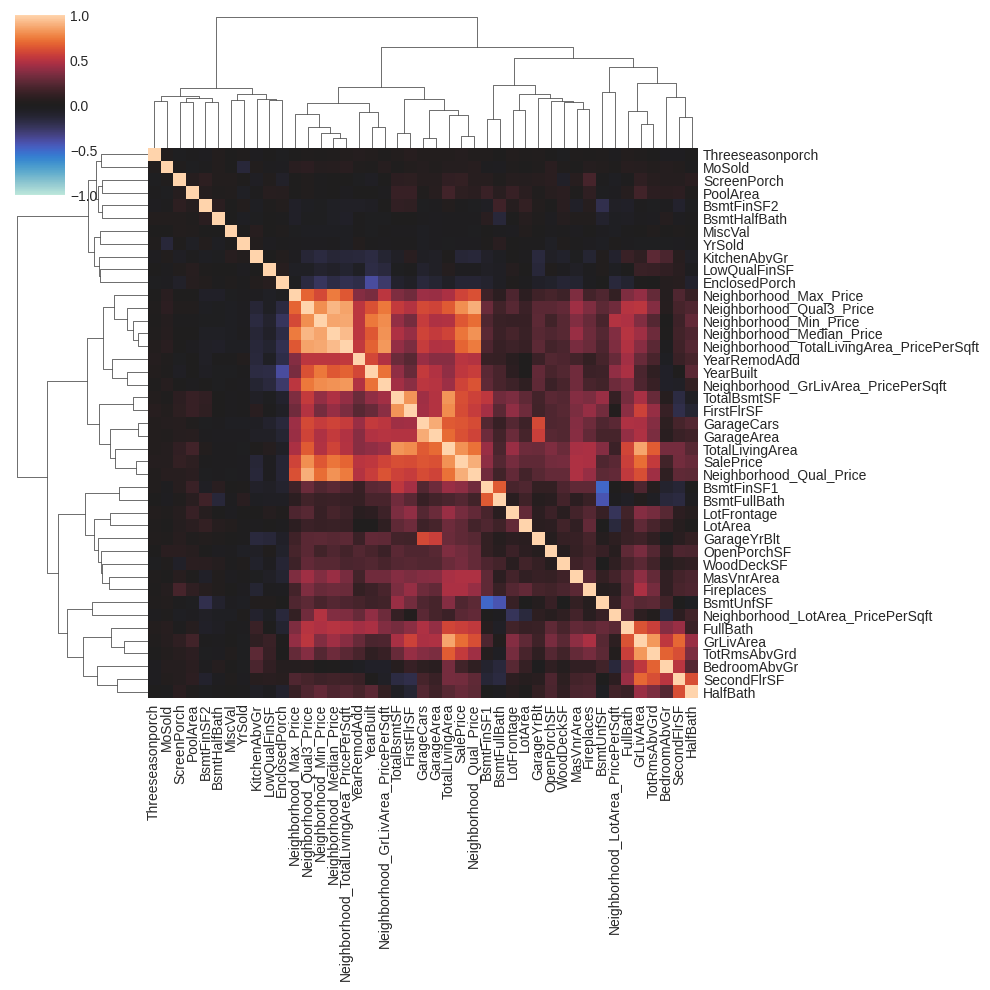

In [ ]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )
corrplot(df_train, annot=None)

Groups of highly correlated features often yield interesting loadings.

### PCA Application - Indicate Outliers ###

In Exercise 5, you applied PCA to determine houses that were **outliers**, that is, houses having values not well represented in the rest of the data. You saw that there was a group of houses in the `Edwards` neighborhood having a `SaleCondition` of `Partial` whose values were especially extreme.

Some models can benefit from having these outliers indicated, which is what this next transform will do.

In [ ]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

You could also consider applying some sort of robust scaler from scikit-learn's `sklearn.preprocessing` module to the outlying values, especially those in `GrLivArea`. [Here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) is a tutorial illustrating some of them. Another option could be to create a feature of "outlier scores" using one of scikit-learn's [outlier detectors](https://scikit-learn.org/stable/modules/outlier_detection.html).

## Target Encoding ##

Needing a separate holdout set to create a target encoding is rather wasteful of data. In *Tutorial 6* we used 25% of our dataset just to encode a single feature, `Zipcode`. The data from the other features in that 25% we didn't get to use at all.

There is, however, a way you can use target encoding without having to use held-out encoding data. It's basically the same trick used in cross-validation:
1. Split the data into folds, each fold having two splits of the dataset.
2. Train the encoder on one split but transform the values of the other.
3. Repeat for all the splits.

This way, training and transformation always take place on independent sets of data, just like when you use a holdout set but without any data going to waste.

In the next hidden cell is a wrapper you can use with any target encoder:

In [ ]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


Use it like:

```
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_encoded = encoder.fit_transform(X, y, cols=["MSSubClass"]))
```

You can turn any of the encoders from the [`category_encoders`](http://contrib.scikit-learn.org/category_encoders/) library into a cross-fold encoder. The [`CatBoostEncoder`](http://contrib.scikit-learn.org/category_encoders/catboost.html) would be worth trying. It's similar to `MEstimateEncoder` but uses some tricks to better prevent overfitting. Its smoothing parameter is called `a` instead of `m`.

## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [ ]:
def create_features(df, df_test=None, debug=False, uninformative_cutoff=0.01):

    # Add aggregate pricing features
    df_with_pricing, df_test_with_pricing = add_pricing_features(
        df_train, df_test, inpute_gaps=True, debug=False)

    X = df_with_pricing.copy() # df.copy()
    y = X.pop("SalePrice")

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test_with_pricing.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])
        debug and print(f"Shapes before creating train/test features: {X.shape}, {X_test.shape}")

    # Lesson 3 - Transformations
    X = X.join(mathematical_transforms(X, debug))
    # X = X.join(interactions(X, debug))
    X = X.join(counts(X, debug))
    X = X.join(break_down(X))
    # X = X.join(group_transforms(X, debug))

    # Lesson 2 - Mutual Information (moving further down because we use YearSold for some of the transformations)
    mi_scores = make_mi_scores(X, y, debug)
    debug and plot_mi_scores(mi_scores)

    # Todo .. can experiment with this
    X = drop_uninformative(X, mi_scores, uninformative_cutoff, debug)

    # Lesson 4 - Clustering <-- circle back
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # Lesson 5 - PCA
    # X = X.join(pca_inspired(X, debug)) <-- circle back
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    debug and print("Label Encoding Fns")
    X = label_encode_new_cols(X, debug)
    X = label_encode(X, debug)
    debug and print(f"Shape after label encoding: {X.shape}")

    for column_name, dtype in X.dtypes.items():
        debug and print(f"Column Name: {column_name}, Data Type: {dtype}")

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
        debug and print(f"Shape after reforming splits: X: {X.shape} X_test: {X_test.shape}")

    # # # Lesson 6 - Target Encoder
    # if y is not None: # Only apply if target (SalePrice) is available
    #   debug and print("Applying Target Encoding...")
    #   target_cols = X.columns.tolist()
    #   debug and print(f"Shape before target encoding (test): {X.shape}")
    #   debug and print(target_cols)

    #   encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    #   X_encoded_target = encoder.fit_transform(X, y, cols=target_cols)
    #   X.join(X_encoded_target)
    #   debug and print(f"Shape after target encoding: {X.shape}")

    # if df_test is not None:
    #   debug and print("Applying target encoding on test: {target_cols}")
    #   X_test_encoded_target = encoder.transform(X_test)
    #   X_test = X_test.join(X_test_encoded_target)
    #   debug and print(f"Shape after target encoding (test): {X_test.shape}")

    if df_test is not None:
        return X, X_test
    else:
        return X

mathematical_transforms
LivLotRatio
Spaciousness
TotalLivingArea
TotalBathrooms
HouseAge
RemodelAge
PorchTypes
Neighborhood_Qual_Price     0.834
Neighborhood_Qual           0.833
TotalLivingArea             0.774
Neighborhood_Qual3          0.645
Neighborhood_Qual3_Price    0.611
                            ...  
Street                      0.000
Utilities                   0.000
PoolArea                    0.000
PoolQC                      0.000
MoSold                      0.000
Name: MI Scores, Length: 100, dtype: float64


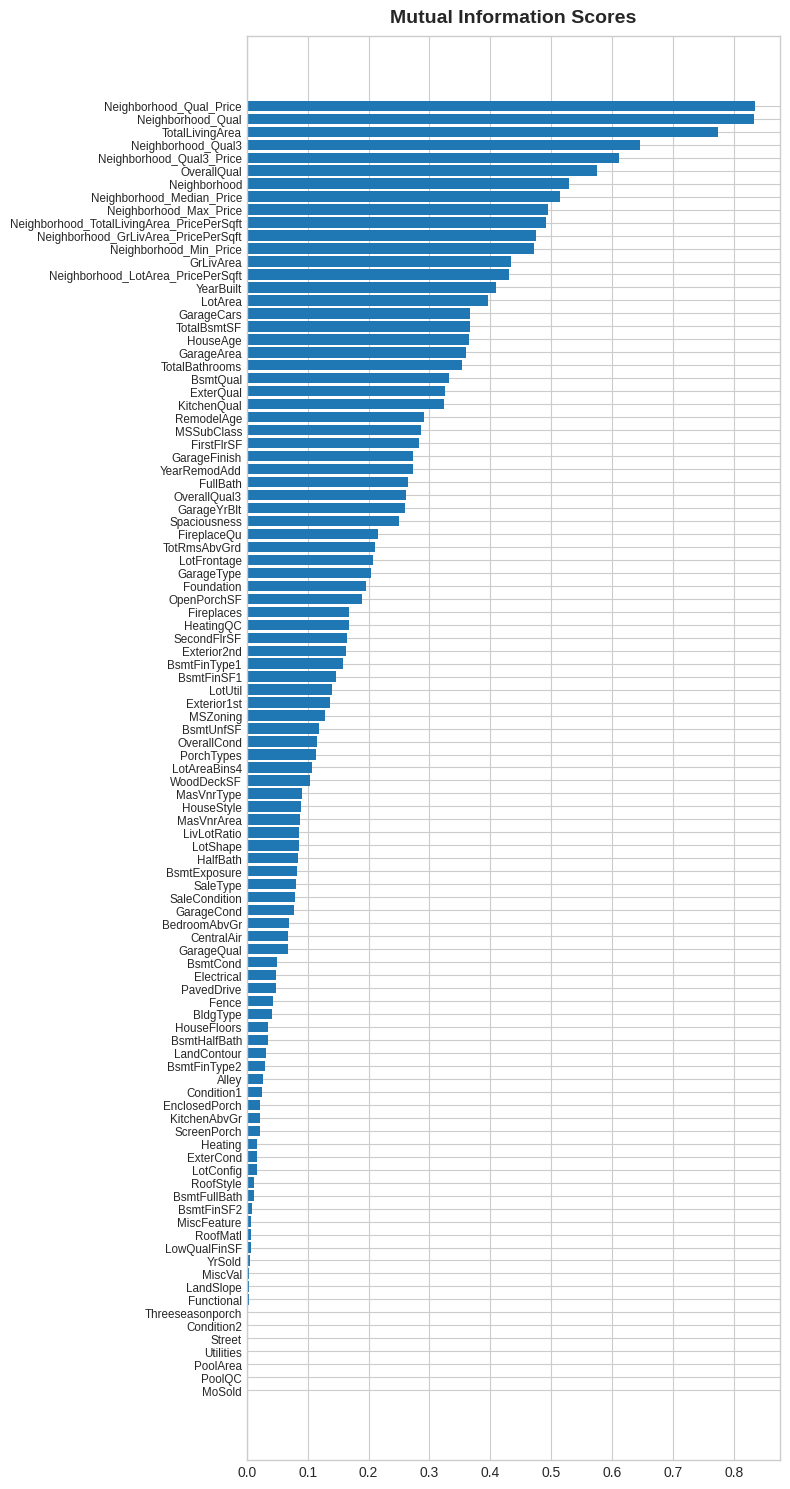

Dropping 31 < 0.0475 features: Index(['Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl',
       'ExterCond', 'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional',
       'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'PoolArea',
       'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold',
       'HouseFloors'],
      dtype='object')
Label Encoding Fns
Label Encoding New Cols
Shape after label encoding: (1460, 69)
Label Encoding Cols
Shape after label encoding: (1460, 69)
Column Name: MSSubClass, Data Type: int8
Column Name: MSZoning, Data Type: int8
Column Name: LotFrontage, Data Type: float64
Column Name: LotArea, Data Type: int64
Column Name: LotShape, Data Type: int8
Column Name: Neighborhood, Data Type: int8
Column Name: HouseStyle, Data Type: int8
Column Name: OverallQual, Data Type: int8
Column Name: 

np.float64(0.13172528403756162)

In [ ]:
# Test Create Features
df_train, df_test = load_data()
X_train = create_features(df_train, debug=True, uninformative_cutoff=0.0475)
y_train = df_train.loc[:, "SalePrice"]
score_dataset(X_train, y_train)

# 0.01 0.13416884115902705 Dropped 15
# 0.05 0.13215089716928696 Dropped 34
# 0.1 0.1350816558090963 Dropped 47
# 0.075 0.13262071898912436 Dropped 37
# 0.025 0.13501041349855014 Dropped 24
# 0.03 0.13453113136592107
# 0.04 0.1318515642773032
# 0.045 0.13172528403756162 Dropped 31

# Step 4 - Hyperparameter Tuning #

At this stage, you might like to do some hyperparameter tuning with XGBoost before creating your final submission.

In [ ]:
# X_train = create_features(df_train)
# y_train = df_train.loc[:, "SalePrice"]

# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )

# xgb = XGBRegressor(**xgb_params)
# score_dataset(X_train, y_train, xgb)

np.float64(0.12162991506215226)

Just tuning these by hand can give you great results. However, you might like to try using one of scikit-learn's automatic [hyperparameter tuners](https://scikit-learn.org/stable/modules/grid_search.html). Or you could explore more advanced tuning libraries like [Optuna](https://optuna.readthedocs.io/en/stable/index.html) or [scikit-optimize](https://scikit-optimize.github.io/stable/).

Here is how you can use Optuna with XGBoost:

```
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params
```

Copy this into a code cell if you'd like to use it, but be aware that it will take quite a while to run. After it's done, you might enjoy using some of [Optuna's visualizations](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html).

I ran the cell below. It's commented out as it takes a long time to run. I've copied and pasted the best selections as markdown comment.


In [ ]:
# %pip install optuna
# import optuna

# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#     )
#     xgb = XGBRegressor(**xgb_params)
#     return score_dataset(X_train, y_train, xgb)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=25)
# xgb_params = study.best_params

[I 2025-07-02 18:47:22,484] A new study created in memory with name: no-name-2e9d8166-3c99-4263-9b1a-f1afd22bb217
[I 2025-07-02 18:47:36,052] Trial 0 finished with value: 0.12512428218650332 and parameters: {'max_depth': 2, 'learning_rate': 0.03232536068347674, 'n_estimators': 4256, 'min_child_weight': 3, 'colsample_bytree': 0.4952851798090975, 'subsample': 0.9607544221231843, 'reg_alpha': 2.610123391961209, 'reg_lambda': 70.30326998389815}. Best is trial 0 with value: 0.12512428218650332.
[I 2025-07-02 18:48:32,968] Trial 1 finished with value: 0.12021092468116261 and parameters: {'max_depth': 7, 'learning_rate': 0.018512706406802887, 'n_estimators': 5339, 'min_child_weight': 5, 'colsample_bytree': 0.5035761317568853, 'subsample': 0.8611493125887957, 'reg_alpha': 0.0037902230011876295, 'reg_lambda': 0.0011072890447337293}. Best is trial 1 with value: 0.12021092468116261.
[I 2025-07-02 18:48:50,630] Trial 2 finished with value: 0.11696541208283344 and parameters: {'max_depth': 4, 'lear

Results:
[I 2025-07-02 19:13:02,309] Trial 24 finished with value: 0.11432650609306935 and parameters: {'max_depth': 4, 'learning_rate': 0.0028781990871983958, 'n_estimators': 5907, 'min_child_weight': 2, 'colsample_bytree': 0.2980327857415928, 'subsample': 0.5622545757424993, 'reg_alpha': 0.0010952592536031334, 'reg_lambda': 0.1892100140439899}. Best is trial 24 with value: 0.11432650609306935.

In [ ]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree
    learning_rate=0.01143,  # effect of each tree
    n_estimators=5907,     # number of trees (that is, boosting rounds)
    min_child_weight=2,    # minimum number of houses in a leaf
    colsample_bytree=0.2980,  # fraction of features (columns) per tree
    subsample=0.5623,         # fraction of instances (rows) per tree
    reg_alpha=0.0010952,       # L1 regularization (like LASSO)
    reg_lambda=0.18921,     # L2 regularization (like Ridge)
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

np.float64(0.11386643491419939)

# Step 5 - Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- create your feature set from the original data
- train XGBoost on the training data
- use the trained model to make predictions from the test set
- save the predictions to a CSV file


In [ ]:
df_train, df_test = load_data()

# Add pricing features before the other features
# Todo incorporate into workflow
X_train, X_test = create_features(df_train, df_test, debug=False, uninformative_cutoff=0.045)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*